# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [6]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


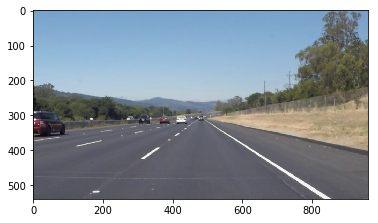

In [7]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [8]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below

    
    Draw lines
    """
    #cv2.line(img, (proc_lines[0][0], proc_lines[0][1]), (proc_lines[0][2], proc_lines[0][3]), [0,255,0], thickness)
    #cv2.line(img, (proc_lines[1][0], proc_lines[1][1]), (proc_lines[1][2], proc_lines[1][3]), [0,255,0], thickness)
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_process_lines(line_img, lines)
   
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

def img_inrange(img, low_color, high_color):
    
    mask = cv2.inRange(img, low_color, up_color)
    
    res = cv2.bitwise_and(img,img, mask= mask)
    
    return res

def process_lines(lines, imshape):
    
    slope_pos = 0.001
    slope_neg = -0.001
    xmin1, ymin1, xmin2, ymin2 = 0, 0, 0, 0
    xmax1, ymax1, xmax2, ymax2 = 0, 0, 0, 0
    
    for line in lines:
        for x1, y1, x2, y2 in line:
            if x1 != x2:
                slope = (y2-y1)/(x2-x1)
                
                if slope <= slope_neg:
                    slope_neg = slope
                    xmin1, ymin1, xmin2, ymin2 = x1, y1, x2, y2
                        
                elif slope >= slope_pos:                  
                    slope_pos = slope
                    xmax1, ymax1, xmax2, ymax2 = x1, y1, x2, y2

                
                """
                if slope <= slope_neg:
                    if abs((slope_neg / slope)-1)< 0.1:
                        slope_neg = slope
                        xmin1 = min(xmin1, x1)
                        ymin2 = min(ymin2, y2)
                        xmin2 = max(xmin2, x2)
                        ymin1 = max(ymin1, y1)
                    else:    
                        slope_neg = slope
                        xmin1, ymin1, xmin2, ymin2 = x1, y1, x2, y2
                            
                elif slope >= slope_pos:
                                       
                    if abs((slope_pos / slope)-1)< 0.1:
                        slope_pos = slope
                        xmax1 = max(x1, xmax1)
                        ymax1 = max(y1, ymax1)
                        xmax2 = min(x2, xmax2)
                        ymax2 = min(y2, ymax2)
                    else:
                        slope_pos = slope
                        xmax1, ymax1, xmax2, ymax2 = x1, y1, x2, y2
                """
    """
    Interpolate lines
    """
    #ymax = 320
    
    """ Solution 1
    y0 = min(ymin2, ymax1)
    y1 = int(imshape[0]/2 + 50)
    ymax = max(y0, y1)
    """
    # Solution 2
    ymax = int(imshape[0]/2 + 50)
    
    
    b1 = ymin1 - slope_neg*xmin1
    yl1 = imshape[0]
    xl1 = int(np.round((yl1 - b1)/slope_neg))
    yl2 = ymax
    xl2 = int(np.round((yl2 - b1)/slope_neg))
    #yl2 = ymin2
    #xl2 = xmin2
    
    b2 = ymax1 - slope_pos*xmax1
    yr2 = imshape[0]
    xr2 = int(np.round((yr2 - b2)/slope_pos))
    yr1 = ymax
    xr1 = int(np.round((yr1 - b2)/slope_pos))
    #yr1 = ymax1
    #xr1 = xmax1
    
    #line_left = np.array([xmin1, ymin1, xmin2, ymin2])
    
    #line_right = np.array([xmax1, ymax1, xmax2, ymax2])

    line_left = np.array([xl1, yl1, xl2, yl2])
    
    line_right = np.array([xr1, yr1, xr2, yr2])
    processed_lines = np.array([line_left,line_right])               
    
    return processed_lines

# draw processed lines

def draw_process_lines(img, lines, color=[255, 0, 0], thickness=5):
    
    """
    
    Process the detected line data
    
    """
    imshape = img.shape
    
    proc_lines = process_lines(lines, imshape)
    
    #print(lines.type)

    #print(proc_lines)
    
    """
    Draw lines
    """
    cv2.line(img, (proc_lines[0][0], proc_lines[0][1]), (proc_lines[0][2], proc_lines[0][3]), [255,0,0], thickness)
    cv2.line(img, (proc_lines[1][0], proc_lines[1][1]), (proc_lines[1][2], proc_lines[1][3]), [255,0,0], thickness)
    
    #for line in lines:
    #    for x1,y1,x2,y2 in line:
    #        cv2.line(img, (x1, y1), (x2, y2), color, thickness)
    

In [9]:
xmin1, ymin1, xmin2, ymin2 = 2, 1, 0, 3
print([xmin1, ymin1, xmin2, ymin2])

a = np.round(1.2)
print(a)


[2, 1, 0, 3]
1.0


## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [10]:
import os
os.listdir("test_images/")

['whiteCarLaneSwitch.jpg',
 'solidYellowLeft.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

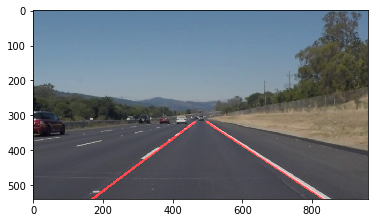

In [16]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#plt.imshow(image)

kernal_size = 5

low_threshold = 70
high_threshold = 210

imshape = image.shape
#print(imshape)

ax = imshape[1]/2 - 30
ay = imshape[0]/2
bx = imshape[1]/2 + 10
by = imshape[0]/2 

vertices = np.array([[(0,imshape[0]),(ax, ay), (bx, by), (imshape[1],imshape[0])]], dtype=np.int32)

rho = 2
theta = np.pi/180
threshold = 15
min_line_len = 30
max_line_gap = 5

low_color = np.array([105, 135, 120])

up_color = np. array([255, 255, 255])

#gray = grayscale(image)

#blur_gray = gaussian_blur(gray, kernal_size)

image_inrange = img_inrange(image, low_color, up_color)

#plt.imshow(blur_gray)
cv2.imwrite(r'test_images_process/solidWhiteRight_image_inrange.jpg',image_inrange)

# Sequence 1
edges = canny(image_inrange, low_threshold, high_threshold)

#plt.imshow(edges)

cv2.imwrite(r'test_images_process/solidWhiteRight_edges.jpg',edges)

masked_edges = region_of_interest(edges, vertices)

# Sequence 2

#edges = region_of_interest(blur_gray, vertices)

#masked_edges = canny(edges, low_threshold, high_threshold)

#plt.imshow(masked_edges)

cv2.imwrite(r'test_images_process/solidWhiteRight_masked_edges.jpg',masked_edges)

line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

#plt.imshow(line_img)

cv2.imwrite(r'test_images_process/solidWhiteRight_line_img.jpg',line_img)

pro_img = weighted_img(line_img, image, α=0.8, β=1., γ=0.)

cv2.imwrite(r'test_images_output/solidWhiteRight.jpg',pro_img)

plt.imshow(pro_img)

## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [171]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [173]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)
    
    kernal_size = 5

    low_threshold = 70
    high_threshold = 210

    imshape = image.shape
    print(imshape)
    ax = imshape[1]/2 - 30
    ay = imshape[0]/2
    bx = imshape[1]/2 + 10
    by = imshape[0]/2 
    
    vertices = np.array([[(0,imshape[0]),(ax, ay), (bx, by), (imshape[1],imshape[0])]], dtype=np.int32)

    rho = 2
    theta = np.pi/180
    threshold = 15
    min_line_len = 30
    max_line_gap = 5

    low_color = np.array([105, 135, 120])

    up_color = np. array([255, 255, 255])

    #gray = grayscale(image)

    #blur_gray = gaussian_blur(gray, kernal_size)

    image_inrange = img_inrange(image, low_color, up_color)

    # Sequence 1
    edges = canny(image_inrange, low_threshold, high_threshold)

    #plt.imshow(edges)

    masked_edges = region_of_interest(edges, vertices)

    #plt.imshow(masked_edges)

    line_img = hough_lines(masked_edges, rho, theta, threshold, min_line_len, max_line_gap)

    #plt.imshow(line_img)

    result = weighted_img(line_img, image, α=0.8, β=1., γ=0.)

    return result

Let's try the one with the solid white lane on the right first ...

In [174]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(5,8)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

(540, 960, 3)
[[169 540 462 320]
 [506 320 847 540]]
[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


  2%|▏         | 4/222 [00:00<00:05, 38.32it/s]

(540, 960, 3)
[[169 540 462 320]
 [506 320 847 540]]
(540, 960, 3)
[[170 540 454 320]
 [501 320 851 540]]
(540, 960, 3)
[[166 540 456 320]
 [501 320 851 540]]
(540, 960, 3)
[[169 540 451 320]
 [524 320 858 540]]
(540, 960, 3)
[[163 540 460 320]
 [503 320 851 540]]
(540, 960, 3)
[[142 540 457 320]
 [504 320 851 540]]
(540, 960, 3)
[[177 540 452 320]
 [505 320 844 540]]
(540, 960, 3)


  6%|▌         | 13/222 [00:00<00:05, 38.64it/s]

[[154 540 447 320]
 [510 320 853 540]]
(540, 960, 3)
[[159 540 461 320]
 [499 320 851 540]]
(540, 960, 3)
[[160 540 460 320]
 [500 320 830 540]]
(540, 960, 3)
[[164 540 463 320]
 [504 320 834 540]]
(540, 960, 3)
[[166 540 465 320]
 [506 320 816 540]]
(540, 960, 3)
[[169 540 457 320]
 [504 320 834 540]]
(540, 960, 3)
[[163 540 455 320]
 [513 320 839 540]]
(540, 960, 3)
[[158 540 458 320]
 [502 320 839 540]]
(540, 960, 3)


  9%|▉         | 21/222 [00:00<00:05, 38.08it/s]

[[156 540 449 320]
 [505 320 811 540]]
(540, 960, 3)
[[170 540 452 320]
 [506 320 829 540]]
(540, 960, 3)
[[169 540 454 320]
 [504 320 840 540]]
(540, 960, 3)
[[167 540 456 320]
 [502 320 837 540]]
(540, 960, 3)
[[158 540 462 320]
 [501 320 838 540]]
(540, 960, 3)
[[161 540 463 320]
 [500 320 836 540]]
(540, 960, 3)
[[179 540 458 320]
 [496 320 835 540]]
(540, 960, 3)
[[164 540 462 320]
 [501 320 835 540]]
(540, 960, 3)


 13%|█▎        | 29/222 [00:00<00:05, 38.10it/s]

[[158 540 465 320]
 [500 320 837 540]]
(540, 960, 3)
[[166 540 456 320]
 [518 320 851 540]]
(540, 960, 3)
[[164 540 464 320]
 [500 320 836 540]]
(540, 960, 3)
[[162 540 462 320]
 [499 320 835 540]]
(540, 960, 3)
[[164 540 455 320]
 [503 320 836 540]]
(540, 960, 3)
[[156 540 458 320]
 [507 320 839 540]]
(540, 960, 3)
[[119 540 460 320]
 [503 320 837 540]]
(540, 960, 3)
[[152 540 467 320]
 [502 320 837 540]]


 17%|█▋        | 37/222 [00:00<00:04, 38.50it/s]

(540, 960, 3)
[[170 540 455 320]
 [503 320 839 540]]
(540, 960, 3)
[[166 540 459 320]
 [512 320 842 540]]
(540, 960, 3)
[[167 540 457 320]
 [503 320 836 540]]
(540, 960, 3)
[[165 540 462 320]
 [502 320 822 540]]
(540, 960, 3)
[[169 540 455 320]
 [498 320 836 540]]
(540, 960, 3)
[[167 540 460 320]
 [504 320 829 540]]
(540, 960, 3)
[[168 540 459 320]
 [497 320 836 540]]
(540, 960, 3)
[[165 540 456 320]
 [508 320 807 540]]


 18%|█▊        | 41/222 [00:01<00:04, 38.12it/s]

(540, 960, 3)
[[162 540 464 320]
 [511 320 833 540]]
(540, 960, 3)
[[148 540 456 320]
 [505 320 832 540]]
(540, 960, 3)
[[146 540 456 320]
 [512 320 833 540]]
(540, 960, 3)
[[169 540 456 320]
 [505 320 822 540]]


 20%|██        | 45/222 [00:01<00:07, 23.05it/s]

(540, 960, 3)
[[155 540 455 320]
 [505 320 832 540]]
(540, 960, 3)
[[168 540 456 320]
 [522 320 832 540]]
(540, 960, 3)
[[173 540 455 320]
 [510 320 825 540]]


 22%|██▏       | 48/222 [00:01<00:09, 19.10it/s]

(540, 960, 3)
[[167 540 453 320]
 [514 320 824 540]]
(540, 960, 3)
[[159 540 458 320]
 [521 320 831 540]]
(540, 960, 3)
[[162 540 455 320]
 [502 320 837 540]]
(540, 960, 3)


 23%|██▎       | 51/222 [00:01<00:09, 17.93it/s]

[[164 540 449 320]
 [503 320 828 540]]
(540, 960, 3)
[[159 540 452 320]
 [503 320 838 540]]
(540, 960, 3)
[[156 540 461 320]
 [504 320 810 540]]
(540, 960, 3)


 24%|██▍       | 54/222 [00:02<00:10, 16.26it/s]

[[113 540 454 320]
 [514 320 832 540]]
(540, 960, 3)
[[108 540 458 320]
 [505 320 832 540]]
(540, 960, 3)
[[147 540 457 320]
 [506 320 826 540]]
(540, 960, 3)
[[146 540 459 320]
 [509 320 823 540]]


 26%|██▌       | 58/222 [00:02<00:10, 15.04it/s]

(540, 960, 3)
[[148 540 460 320]
 [498 320 834 540]]
(540, 960, 3)
[[156 540 458 320]
 [511 320 825 540]]
(540, 960, 3)
[[150 540 459 320]
 [495 320 829 540]]
(540, 960, 3)


 28%|██▊       | 62/222 [00:02<00:10, 14.78it/s]

[[144 540 465 320]
 [501 320 827 540]]
(540, 960, 3)
[[148 540 462 320]
 [501 320 826 540]]
(540, 960, 3)
[[154 540 453 320]
 [498 320 817 540]]
(540, 960, 3)


 29%|██▉       | 64/222 [00:02<00:11, 14.22it/s]

[[150 540 450 320]
 [504 320 821 540]]
(540, 960, 3)
[[149 540 461 320]
 [504 320 823 540]]
(540, 960, 3)
[[144 540 460 320]
 [497 320 823 540]]
(540, 960, 3)


 31%|███       | 68/222 [00:03<00:10, 14.39it/s]

[[139 540 459 320]
 [520 320 840 540]]
(540, 960, 3)
[[138 540 458 320]
 [500 320 825 540]]
(540, 960, 3)
[[140 540 455 320]
 [499 320 825 540]]
(540, 960, 3)


 32%|███▏      | 70/222 [00:03<00:10, 14.53it/s]

[[146 540 457 320]
 [518 320 840 540]]
(540, 960, 3)
[[154 540 450 320]
 [498 320 824 540]]
(540, 960, 3)
[[145 540 454 320]
 [519 320 844 540]]
(540, 960, 3)


 33%|███▎      | 74/222 [00:03<00:10, 13.48it/s]

[[147 540 450 320]
 [514 320 838 540]]
(540, 960, 3)
[[146 540 454 320]
 [498 320 824 540]]
(540, 960, 3)
[[146 540 451 320]
 [499 320 823 540]]


 34%|███▍      | 76/222 [00:03<00:10, 13.80it/s]

(540, 960, 3)
[[142 540 455 320]
 [519 320 843 540]]
(540, 960, 3)
[[152 540 455 320]
 [498 320 823 540]]
(540, 960, 3)
[[141 540 453 320]
 [498 320 821 540]]


 36%|███▌      | 80/222 [00:03<00:09, 14.27it/s]

(540, 960, 3)
[[ 96 540 455 320]
 [499 320 821 540]]
(540, 960, 3)
[[143 540 453 320]
 [499 320 814 540]]
(540, 960, 3)
[[142 540 454 320]
 [505 320 813 540]]
(540, 960, 3)


 37%|███▋      | 82/222 [00:04<00:09, 14.33it/s]

[[139 540 454 320]
 [500 320 797 540]]
(540, 960, 3)
[[137 540 455 320]
 [508 320 804 540]]
(540, 960, 3)
[[143 540 448 320]
 [502 320 787 540]]
(540, 960, 3)


 39%|███▊      | 86/222 [00:04<00:09, 14.62it/s]

[[133 540 455 320]
 [504 320 811 540]]
(540, 960, 3)
[[143 540 456 320]
 [502 320 812 540]]
(540, 960, 3)
[[137 540 456 320]
 [507 320 806 540]]
(540, 960, 3)
[[135 540 462 320]
 [509 320 822 540]]


 41%|████      | 90/222 [00:04<00:09, 14.25it/s]

(540, 960, 3)
[[139 540 457 320]
 [500 320 803 540]]
(540, 960, 3)
[[114 540 453 320]
 [501 320 796 540]]
(540, 960, 3)
[[130 540 460 320]
 [510 320 807 540]]


 41%|████▏     | 92/222 [00:04<00:08, 14.48it/s]

(540, 960, 3)
[[132 540 462 320]
 [511 320 810 540]]
(540, 960, 3)
[[156 540 458 320]
 [508 320 806 540]]
(540, 960, 3)
[[133 540 460 320]
 [512 320 802 540]]
(540, 960, 3)


 43%|████▎     | 96/222 [00:04<00:08, 14.78it/s]

[[147 540 456 320]
 [512 320 809 540]]
(540, 960, 3)
[[137 540 464 320]
 [502 320 812 540]]
(540, 960, 3)
[[152 540 459 320]
 [513 320 812 540]]
(540, 960, 3)


 44%|████▍     | 98/222 [00:05<00:08, 14.85it/s]

[[139 540 456 320]
 [507 320 809 540]]
(540, 960, 3)
[[138 540 449 320]
 [512 320 811 540]]
(540, 960, 3)
[[138 540 452 320]
 [509 320 813 540]]
(540, 960, 3)
[[134 540 457 320]
 [509 320 813 540]]


 46%|████▌     | 102/222 [00:05<00:07, 15.23it/s]

(540, 960, 3)
[[135 540 461 320]
 [515 320 815 540]]
(540, 960, 3)
[[113 540 458 320]
 [512 320 808 540]]
(540, 960, 3)
[[142 540 467 320]
 [504 320 816 540]]


 48%|████▊     | 106/222 [00:05<00:07, 14.76it/s]

(540, 960, 3)
[[142 540 462 320]
 [501 320 815 540]]
(540, 960, 3)
[[147 540 464 320]
 [505 320 816 540]]
(540, 960, 3)
[[153 540 459 320]
 [510 320 807 540]]
(540, 960, 3)


 49%|████▊     | 108/222 [00:05<00:07, 14.82it/s]

[[155 540 458 320]
 [504 320 818 540]]
(540, 960, 3)
[[148 540 464 320]
 [507 320 819 540]]
(540, 960, 3)
[[154 540 451 320]
 [521 320 832 540]]
(540, 960, 3)


 50%|█████     | 112/222 [00:06<00:07, 14.55it/s]

[[151 540 464 320]
 [513 320 810 540]]
(540, 960, 3)
[[153 540 460 320]
 [526 320 839 540]]
(540, 960, 3)
[[155 540 454 320]
 [507 320 821 540]]
(540, 960, 3)


 51%|█████▏    | 114/222 [00:06<00:07, 14.62it/s]

[[151 540 460 320]
 [507 320 821 540]]
(540, 960, 3)
[[126 540 464 320]
 [507 320 822 540]]
(540, 960, 3)
[[146 540 460 320]
 [512 320 820 540]]
(540, 960, 3)
[[129 540 454 320]
 [527 320 846 540]]


 53%|█████▎    | 118/222 [00:06<00:07, 14.72it/s]

(540, 960, 3)
[[164 540 450 320]
 [506 320 820 540]]
(540, 960, 3)
[[151 540 458 320]
 [508 320 801 540]]
(540, 960, 3)
[[149 540 459 320]
 [510 320 829 540]]
(540, 960, 3)


 55%|█████▍    | 122/222 [00:06<00:06, 14.76it/s]

[[147 540 462 320]
 [508 320 826 540]]
(540, 960, 3)
[[150 540 463 320]
 [503 320 822 540]]
(540, 960, 3)
[[150 540 463 320]
 [503 320 813 540]]
(540, 960, 3)


 56%|█████▌    | 124/222 [00:06<00:06, 14.84it/s]

[[151 540 461 320]
 [504 320 831 540]]
(540, 960, 3)
[[151 540 459 320]
 [509 320 819 540]]
(540, 960, 3)
[[149 540 452 320]
 [511 320 834 540]]
(540, 960, 3)
[[143 540 463 320]
 [508 320 833 540]]


 58%|█████▊    | 128/222 [00:07<00:06, 14.85it/s]

(540, 960, 3)
[[157 540 464 320]
 [506 320 834 540]]
(540, 960, 3)
[[156 540 464 320]
 [504 320 840 540]]
(540, 960, 3)
[[161 540 464 320]
 [502 320 841 540]]
(540, 960, 3)


 59%|█████▉    | 132/222 [00:07<00:06, 14.87it/s]

[[156 540 466 320]
 [503 320 840 540]]
(540, 960, 3)
[[168 540 461 320]
 [509 320 840 540]]
(540, 960, 3)
[[169 540 465 320]
 [502 320 840 540]]
(540, 960, 3)


 60%|██████    | 134/222 [00:07<00:06, 13.43it/s]

[[169 540 455 320]
 [524 320 859 540]]
(540, 960, 3)
[[162 540 466 320]
 [503 320 838 540]]
(540, 960, 3)
[[165 540 456 320]
 [510 320 826 540]]


 62%|██████▏   | 138/222 [00:07<00:05, 14.00it/s]

(540, 960, 3)
[[179 540 414 320]
 [518 320 851 540]]
(540, 960, 3)
[[162 540 458 320]
 [506 320 844 540]]
(540, 960, 3)
[[-2394   540   114   320]
 [  529   320   864   540]]
(540, 960, 3)


 63%|██████▎   | 140/222 [00:08<00:05, 13.92it/s]

[[149 540 462 320]
 [506 320 843 540]]
(540, 960, 3)
[[161 540 467 320]
 [505 320 843 540]]
(540, 960, 3)
[[176 540 461 320]
 [508 320 823 540]]
(540, 960, 3)


 65%|██████▍   | 144/222 [00:08<00:05, 13.92it/s]

[[170 540 466 320]
 [503 320 841 540]]
(540, 960, 3)
[[176 540 459 320]
 [502 320 840 540]]
(540, 960, 3)
[[170 540 462 320]
 [503 320 840 540]]
(540, 960, 3)


 66%|██████▌   | 146/222 [00:08<00:05, 14.12it/s]

[[174 540 459 320]
 [519 320 833 540]]
(540, 960, 3)
[[173 540 460 320]
 [506 320 844 540]]
(540, 960, 3)
[[171 540 456 320]
 [509 320 847 540]]
(540, 960, 3)


 68%|██████▊   | 150/222 [00:08<00:05, 14.26it/s]

[[170 540 453 320]
 [508 320 846 540]]
(540, 960, 3)
[[170 540 450 320]
 [512 320 837 540]]
(540, 960, 3)
[[153 540 463 320]
 [512 320 842 540]]
(540, 960, 3)
[[176 540 461 320]
 [516 320 841 540]]


 69%|██████▉   | 154/222 [00:08<00:04, 14.56it/s]

(540, 960, 3)
[[179 540 465 320]
 [503 320 851 540]]
(540, 960, 3)
[[181 540 460 320]
 [518 320 838 540]]
(540, 960, 3)
[[175 540 464 320]
 [508 320 838 540]]
(540, 960, 3)


 70%|███████   | 156/222 [00:09<00:04, 14.31it/s]

[[178 540 460 320]
 [518 320 848 540]]
(540, 960, 3)
[[187 540 462 320]
 [532 320 861 540]]
(540, 960, 3)
[[173 540 464 320]
 [516 320 846 540]]
(540, 960, 3)
[[174 540 458 320]
 [518 320 852 540]]


 72%|███████▏  | 160/222 [00:09<00:04, 14.54it/s]

(540, 960, 3)
[[174 540 459 320]
 [504 320 863 540]]
(540, 960, 3)
[[177 540 458 320]
 [508 320 860 540]]
(540, 960, 3)
[[184 540 463 320]
 [510 320 862 540]]


 73%|███████▎  | 162/222 [00:09<00:04, 14.33it/s]

(540, 960, 3)
[[159 540 465 320]
 [505 320 867 540]]
(540, 960, 3)
[[173 540 466 320]
 [504 320 867 540]]
(540, 960, 3)
[[191 540 466 320]
 [540 320 888 540]]


 75%|███████▍  | 166/222 [00:09<00:03, 14.11it/s]

(540, 960, 3)
[[193 540 463 320]
 [526 320 888 540]]
(540, 960, 3)
[[192 540 465 320]
 [509 320 857 540]]
(540, 960, 3)
[[193 540 466 320]
 [502 320 866 540]]


 77%|███████▋  | 170/222 [00:10<00:03, 14.16it/s]

(540, 960, 3)
[[195 540 462 320]
 [523 320 887 540]]
(540, 960, 3)
[[196 540 465 320]
 [502 320 865 540]]
(540, 960, 3)
[[193 540 468 320]
 [501 320 867 540]]
(540, 960, 3)


 77%|███████▋  | 172/222 [00:10<00:03, 14.18it/s]

[[203 540 465 320]
 [501 320 867 540]]
(540, 960, 3)
[[192 540 467 320]
 [499 320 865 540]]
(540, 960, 3)
[[193 540 456 320]
 [503 320 867 540]]
(540, 960, 3)


 79%|███████▉  | 176/222 [00:10<00:03, 14.27it/s]

[[166 540 463 320]
 [501 320 867 540]]
(540, 960, 3)
[[200 540 464 320]
 [501 320 867 540]]
(540, 960, 3)
[[170 540 466 320]
 [506 320 862 540]]
(540, 960, 3)
[[197 540 466 320]
 [499 320 865 540]]


 80%|████████  | 178/222 [00:10<00:03, 13.66it/s]

(540, 960, 3)
[[204 540 464 320]
 [504 320 866 540]]
(540, 960, 3)
[[198 540 466 320]
 [502 320 868 540]]
(540, 960, 3)
[[200 540 465 320]
 [518 320 862 540]]


 82%|████████▏ | 182/222 [00:11<00:02, 13.77it/s]

(540, 960, 3)
[[195 540 464 320]
 [504 320 869 540]]
(540, 960, 3)
[[199 540 469 320]
 [508 320 870 540]]
(540, 960, 3)
[[199 540 456 320]
 [514 320 857 540]]


 84%|████████▍ | 186/222 [00:11<00:02, 13.98it/s]

(540, 960, 3)
[[199 540 461 320]
 [505 320 871 540]]
(540, 960, 3)
[[199 540 459 320]
 [517 320 863 540]]
(540, 960, 3)
[[166 540 465 320]
 [510 320 866 540]]
(540, 960, 3)


 85%|████████▍ | 188/222 [00:11<00:02, 13.96it/s]

[[-2050   540   150   320]
 [  507   320   870   540]]
(540, 960, 3)
[[189 540 464 320]
 [507 320 873 540]]
(540, 960, 3)
[[174 540 461 320]
 [512 320 879 540]]
(540, 960, 3)
[[187 540 462 320]
 [521 320 883 540]]


 86%|████████▋ | 192/222 [00:11<00:02, 14.41it/s]

(540, 960, 3)
[[195 540 459 320]
 [527 320 886 540]]
(540, 960, 3)
[[196 540 463 320]
 [519 320 883 540]]
(540, 960, 3)
[[199 540 467 320]
 [517 320 869 540]]


 87%|████████▋ | 194/222 [00:11<00:02, 13.61it/s]

(540, 960, 3)
[[197 540 466 320]
 [519 320 859 540]]
(540, 960, 3)
[[197 540 468 320]
 [505 320 867 540]]
(540, 960, 3)
[[197 540 468 320]
 [519 320 883 540]]


 89%|████████▉ | 198/222 [00:12<00:01, 13.54it/s]

(540, 960, 3)
[[198 540 455 320]
 [518 320 884 540]]
(540, 960, 3)
[[162 540 465 320]
 [502 320 869 540]]
(540, 960, 3)
[[166 540 462 320]
 [505 320 844 540]]


 90%|█████████ | 200/222 [00:12<00:01, 13.73it/s]

(540, 960, 3)
[[183 540 458 320]
 [516 320 868 540]]
(540, 960, 3)
[[197 540 466 320]
 [507 320 868 540]]
(540, 960, 3)
[[201 540 461 320]
 [518 320 877 540]]


 92%|█████████▏| 204/222 [00:12<00:01, 14.11it/s]

(540, 960, 3)
[[201 540 462 320]
 [519 320 871 540]]
(540, 960, 3)
[[202 540 458 320]
 [510 320 878 540]]
(540, 960, 3)
[[197 540 460 320]
 [514 320 866 540]]


 93%|█████████▎| 206/222 [00:12<00:01, 13.78it/s]

(540, 960, 3)
[[196 540 467 320]
 [511 320 879 540]]
(540, 960, 3)
[[197 540 460 320]
 [507 320 888 540]]
(540, 960, 3)
[[198 540 450 320]
 [514 320 877 540]]


 95%|█████████▍| 210/222 [00:12<00:00, 14.33it/s]

(540, 960, 3)
[[198 540 458 320]
 [511 320 881 540]]
(540, 960, 3)
[[188 540 463 320]
 [505 320 887 540]]
(540, 960, 3)
[[-2430   540    63   320]
 [  521   320   895   540]]


 96%|█████████▋| 214/222 [00:13<00:00, 14.52it/s]

(540, 960, 3)
[[171 540 467 320]
 [505 320 886 540]]
(540, 960, 3)
[[195 540 464 320]
 [520 320 883 540]]
(540, 960, 3)
[[195 540 465 320]
 [501 320 881 540]]


 97%|█████████▋| 216/222 [00:13<00:00, 14.18it/s]

(540, 960, 3)
[[203 540 461 320]
 [502 320 882 540]]
(540, 960, 3)
[[202 540 465 320]
 [499 320 880 540]]
(540, 960, 3)
[[203 540 460 320]
 [519 320 894 540]]


 99%|█████████▉| 220/222 [00:13<00:00, 13.97it/s]

(540, 960, 3)
[[200 540 456 320]
 [531 320 898 540]]
(540, 960, 3)
[[197 540 466 320]
 [500 320 879 540]]
(540, 960, 3)
[[196 540 454 320]
 [514 320 881 540]]


100%|█████████▉| 221/222 [00:13<00:00, 16.05it/s]


(540, 960, 3)
[[194 540 463 320]
 [508 320 857 540]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 3.3 s, sys: 287 ms, total: 3.59 s
Wall time: 15.5 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [175]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [176]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

(540, 960, 3)
[[134 540 460 320]
 [518 320 814 540]]
[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


  1%|          | 4/682 [00:00<00:18, 37.04it/s]

(540, 960, 3)
[[134 540 460 320]
 [518 320 814 540]]
(540, 960, 3)
[[278 540 456 320]
 [514 320 793 540]]
(540, 960, 3)
[[ 94 540 394 320]
 [510 320 818 540]]
(540, 960, 3)
[[111 540 393 320]
 [514 320 819 540]]
(540, 960, 3)
[[126 540 423 320]
 [518 320 822 540]]
(540, 960, 3)
[[105 540 392 320]
 [514 320 800 540]]
(540, 960, 3)
[[147 540 467 320]
 [511 320 815 540]]
(540, 960, 3)


  2%|▏         | 12/682 [00:00<00:17, 37.56it/s]

[[148 540 467 320]
 [513 320 819 540]]
(540, 960, 3)
[[133 540 471 320]
 [515 320 684 540]]
(540, 960, 3)
[[282 540 455 320]
 [518 320 788 540]]
(540, 960, 3)
[[183 540 455 320]
 [516 320 803 540]]
(540, 960, 3)
[[286 540 455 320]
 [513 320 831 540]]
(540, 960, 3)
[[124 540 465 320]
 [517 320 831 540]]
(540, 960, 3)
[[167 540 463 320]
 [530 320 831 540]]
(540, 960, 3)
[[148 540 466 320]
 [527 320 834 540]]
(540, 960, 3)


  3%|▎         | 20/682 [00:00<00:17, 37.68it/s]

[[232 540 452 320]
 [518 320 837 540]]
(540, 960, 3)
[[232 540 452 320]
 [517 320 799 540]]
(540, 960, 3)
[[   183    540    460    320]
 [320000    320 540000    540]]
(540, 960, 3)
[[   207    540    451    320]
 [320000    320 540000    540]]
(540, 960, 3)
[[137 540 462 320]
 [512 320 828 540]]
(540, 960, 3)
[[256 540 449 320]
 [517 320 825 540]]
(540, 960, 3)
[[170 540 451 320]
 [514 320 833 540]]
(540, 960, 3)
[[162 540 453 320]
 [517 320 831 540]]
(540, 960, 3)


  4%|▍         | 28/682 [00:00<00:17, 37.71it/s]

[[177 540 455 320]
 [518 320 799 540]]
(540, 960, 3)
[[187 540 450 320]
 [515 320 835 540]]
(540, 960, 3)
[[225 540 450 320]
 [505 320 845 540]]
(540, 960, 3)
[[229 540 449 320]
 [505 320 850 540]]
(540, 960, 3)
[[216 540 448 320]
 [519 320 812 540]]
(540, 960, 3)
[[139 540 455 320]
 [523 320 853 540]]
(540, 960, 3)
[[196 540 453 320]
 [520 320 805 540]]
(540, 960, 3)
[[234 540 447 320]
 [522 320 822 540]]
(540, 960, 3)


  5%|▌         | 37/682 [00:00<00:16, 38.33it/s]

[[266 540 449 320]
 [521 320 820 540]]
(540, 960, 3)
[[206 540 451 320]
 [522 320 844 540]]
(540, 960, 3)
[[195 540 447 320]
 [518 320 844 540]]
(540, 960, 3)
[[260 540 448 320]
 [522 320 837 540]]
(540, 960, 3)
[[150 540 434 320]
 [523 320 811 540]]
(540, 960, 3)
[[174 540 448 320]
 [521 320 847 540]]
(540, 960, 3)
[[184 540 445 320]
 [521 320 855 540]]
(540, 960, 3)
[[171 540 451 320]
 [525 320 850 540]]
(540, 960, 3)


  6%|▌         | 41/682 [00:01<00:17, 37.68it/s]

[[195 540 449 320]
 [524 320 864 540]]
(540, 960, 3)
[[183 540 441 320]
 [522 320 859 540]]
(540, 960, 3)
[[152 540 433 320]
 [523 320 863 540]]
(540, 960, 3)
[[172 540 444 320]
 [522 320 827 540]]


  7%|▋         | 45/682 [00:01<00:26, 23.89it/s]

(540, 960, 3)
[[150 540 425 320]
 [515 320 684 540]]
(540, 960, 3)
[[193 540 446 320]
 [511 320 850 540]]
(540, 960, 3)
[[165 540 446 320]
 [516 320 846 540]]


  7%|▋         | 48/682 [00:01<00:31, 20.05it/s]

(540, 960, 3)
[[190 540 451 320]
 [515 320 840 540]]
(540, 960, 3)
[[168 540 452 320]
 [516 320 841 540]]
(540, 960, 3)
[[200 540 445 320]
 [514 320 848 540]]
(540, 960, 3)


  7%|▋         | 51/682 [00:01<00:35, 17.80it/s]

[[199 540 445 320]
 [503 320 862 540]]
(540, 960, 3)
[[197 540 450 320]
 [518 320 804 540]]
(540, 960, 3)
[[146 540 432 320]
 [516 320 812 540]]
(540, 960, 3)
[[198 540 452 320]
 [514 320 813 540]]


  8%|▊         | 56/682 [00:02<00:38, 16.30it/s]

(540, 960, 3)
[[193 540 452 320]
 [515 320 856 540]]
(540, 960, 3)
[[157 540 449 320]
 [515 320 826 540]]
(540, 960, 3)
[[   200    540    420    320]
 [320000    320 540000    540]]
(540, 960, 3)


  9%|▊         | 58/682 [00:02<00:40, 15.28it/s]

[[176 540 448 320]
 [508 320 843 540]]
(540, 960, 3)
[[158 540 440 320]
 [515 320 814 540]]
(540, 960, 3)
[[158 540 425 320]
 [510 320 869 540]]
(540, 960, 3)

  9%|▉         | 60/682 [00:02<00:41, 14.91it/s]


[[154 540 425 320]
 [508 320 842 540]]
(540, 960, 3)
[[179 540 448 320]
 [511 320 838 540]]
(540, 960, 3)
[[193 540 447 320]
 [513 320 826 540]]


  9%|▉         | 64/682 [00:02<00:42, 14.55it/s]

(540, 960, 3)
[[136 540 440 320]
 [516 320 803 540]]
(540, 960, 3)
[[135 540 443 320]
 [514 320 808 540]]
(540, 960, 3)
[[159 540 413 320]
 [515 320 801 540]]


 10%|▉         | 66/682 [00:02<00:43, 14.08it/s]

(540, 960, 3)
[[170 540 449 320]
 [512 320 818 540]]
(540, 960, 3)
[[173 540 454 320]
 [507 320 847 540]]
(540, 960, 3)
[[174 540 453 320]
 [510 320 840 540]]


 10%|█         | 70/682 [00:03<00:43, 14.02it/s]

(540, 960, 3)
[[194 540 450 320]
 [507 320 865 540]]
(540, 960, 3)
[[173 540 450 320]
 [504 320 834 540]]
(540, 960, 3)
[[193 540 455 320]
 [512 320 823 540]]


 11%|█         | 74/682 [00:03<00:43, 13.87it/s]

(540, 960, 3)
[[139 540 429 320]
 [512 320 828 540]]
(540, 960, 3)
[[180 540 454 320]
 [511 320 819 540]]
(540, 960, 3)
[[154 540 437 320]
 [509 320 840 540]]
(540, 960, 3)


 11%|█         | 76/682 [00:03<00:42, 14.15it/s]

[[172 540 448 320]
 [500 320 840 540]]
(540, 960, 3)
[[161 540 453 320]
 [510 320 801 540]]
(540, 960, 3)
[[190 540 451 320]
 [505 320 839 540]]
(540, 960, 3)
[[166 540 450 320]
 [509 320 800 540]]

 12%|█▏        | 80/682 [00:03<00:42, 14.19it/s]


(540, 960, 3)
[[183 540 455 320]
 [509 320 793 540]]
(540, 960, 3)
[[162 540 451 320]
 [508 320 829 540]]
(540, 960, 3)


 12%|█▏        | 82/682 [00:04<00:41, 14.30it/s]

[[170 540 451 320]
 [510 320 830 540]]
(540, 960, 3)
[[174 540 455 320]
 [510 320 813 540]]
(540, 960, 3)
[[177 540 450 320]
 [511 320 815 540]]
(540, 960, 3)
[[136 540 427 320]
 [506 320 830 540]]


 13%|█▎        | 86/682 [00:04<00:41, 14.54it/s]

(540, 960, 3)
[[162 540 449 320]
 [509 320 824 540]]
(540, 960, 3)
[[143 540 440 320]
 [506 320 831 540]]
(540, 960, 3)
[[174 540 455 320]
 [508 320 798 540]]


 13%|█▎        | 88/682 [00:04<00:42, 13.95it/s]

(540, 960, 3)
[[187 540 451 320]
 [514 320 824 540]]
(540, 960, 3)
[[169 540 433 320]
 [512 320 807 540]]
(540, 960, 3)
[[201 540 455 320]
 [512 320 799 540]]


 13%|█▎        | 92/682 [00:04<00:41, 14.22it/s]

(540, 960, 3)
[[136 540 451 320]
 [510 320 803 540]]
(540, 960, 3)
[[184 540 454 320]
 [504 320 807 540]]
(540, 960, 3)
[[183 540 460 320]
 [507 320 832 540]]


 14%|█▍        | 94/682 [00:04<00:42, 13.85it/s]

(540, 960, 3)
[[149 540 464 320]
 [507 320 807 540]]
(540, 960, 3)
[[140 540 456 320]
 [506 320 816 540]]
(540, 960, 3)
[[171 540 463 320]
 [507 320 807 540]]


 14%|█▍        | 98/682 [00:05<00:41, 14.02it/s]

(540, 960, 3)
[[157 540 462 320]
 [499 320 824 540]]
(540, 960, 3)
[[155 540 462 320]
 [506 320 816 540]]
(540, 960, 3)
[[165 540 456 320]
 [507 320 822 540]]
(540, 960, 3)


 15%|█▍        | 102/682 [00:05<00:40, 14.23it/s]

[[153 540 456 320]
 [509 320 804 540]]
(540, 960, 3)
[[136 540 421 320]
 [509 320 804 540]]
(540, 960, 3)
[[158 540 461 320]
 [505 320 831 540]]
(540, 960, 3)


 15%|█▌        | 104/682 [00:05<00:42, 13.72it/s]

[[176 540 460 320]
 [506 320 807 540]]
(540, 960, 3)
[[156 540 456 320]
 [495 320 835 540]]
(540, 960, 3)
[[155 540 460 320]
 [504 320 834 540]]
(540, 960, 3)


 16%|█▌        | 108/682 [00:05<00:41, 13.86it/s]

[[142 540 438 320]
 [510 320 830 540]]
(540, 960, 3)
[[167 540 458 320]
 [506 320 855 540]]
(540, 960, 3)
[[145 540 445 320]
 [503 320 828 540]]
(540, 960, 3)


 16%|█▌        | 110/682 [00:06<00:41, 13.73it/s]

[[171 540 459 320]
 [504 320 807 540]]
(540, 960, 3)
[[177 540 461 320]
 [504 320 834 540]]
(540, 960, 3)
[[162 540 457 320]
 [504 320 834 540]]
(540, 960, 3)


 17%|█▋        | 114/682 [00:06<00:41, 13.58it/s]

[[160 540 463 320]
 [505 320 827 540]]
(540, 960, 3)
[[169 540 449 320]
 [499 320 836 540]]
(540, 960, 3)
[[159 540 462 320]
 [510 320 824 540]]
(540, 960, 3)


 17%|█▋        | 116/682 [00:06<00:41, 13.65it/s]

[[162 540 456 320]
 [505 320 831 540]]
(540, 960, 3)
[[169 540 461 320]
 [500 320 839 540]]
(540, 960, 3)
[[154 540 450 320]
 [512 320 832 540]]
(540, 960, 3)
[[140 540 453 320]
 [508 320 838 540]]


 18%|█▊        | 120/682 [00:06<00:40, 13.99it/s]

(540, 960, 3)
[[165 540 449 320]
 [509 320 839 540]]
(540, 960, 3)
[[148 540 446 320]
 [503 320 834 540]]
(540, 960, 3)
[[141 540 426 320]
 [512 320 815 540]]


 18%|█▊        | 122/682 [00:06<00:40, 13.73it/s]

(540, 960, 3)
[[138 540 449 320]
 [506 320 841 540]]
(540, 960, 3)
[[143 540 464 320]
 [509 320 844 540]]
(540, 960, 3)
[[174 540 425 320]
 [505 320 829 540]]


 18%|█▊        | 126/682 [00:07<00:40, 13.88it/s]

(540, 960, 3)
[[177 540 461 320]
 [509 320 831 540]]
(540, 960, 3)
[[147 540 461 320]
 [558 320 883 540]]
(540, 960, 3)
[[142 540 452 320]
 [507 320 837 540]]
(540, 960, 3)


 19%|█▉        | 130/682 [00:07<00:38, 14.19it/s]

[[143 540 455 320]
 [501 320 839 540]]
(540, 960, 3)
[[152 540 467 320]
 [514 320 832 540]]
(540, 960, 3)
[[153 540 446 320]
 [507 320 840 540]]
(540, 960, 3)


 19%|█▉        | 132/682 [00:07<00:38, 14.31it/s]

[[146 540 466 320]
 [510 320 840 540]]
(540, 960, 3)
[[138 540 463 320]
 [502 320 862 540]]
(540, 960, 3)
[[170 540 454 320]
 [502 320 837 540]]
(540, 960, 3)


 20%|█▉        | 136/682 [00:07<00:40, 13.43it/s]

[[161 540 467 320]
 [497 320 841 540]]
(540, 960, 3)
[[162 540 441 320]
 [510 320 821 540]]
(540, 960, 3)
[[168 540 464 320]
 [496 320 840 540]]
(540, 960, 3)


 20%|██        | 138/682 [00:08<00:40, 13.57it/s]

[[149 540 434 320]
 [503 320 834 540]]
(540, 960, 3)
[[148 540 464 320]
 [505 320 833 540]]
(540, 960, 3)
[[154 540 435 320]
 [498 320 839 540]]
(540, 960, 3)
[[147 540 467 320]
 [517 320 834 540]]

 21%|██        | 142/682 [00:08<00:38, 13.90it/s]


(540, 960, 3)
[[139 540 463 320]
 [506 320 836 540]]
(540, 960, 3)
[[154 540 467 320]
 [514 320 839 540]]
(540, 960, 3)


 21%|██        | 144/682 [00:08<00:38, 13.94it/s]

[[171 540 452 320]
 [497 320 842 540]]
(540, 960, 3)
[[155 540 448 320]
 [501 320 871 540]]
(540, 960, 3)
[[170 540 466 320]
 [502 320 832 540]]
(540, 960, 3)


 22%|██▏       | 148/682 [00:08<00:39, 13.52it/s]

[[147 540 450 320]
 [499 320 839 540]]
(540, 960, 3)
[[159 540 467 320]
 [496 320 842 540]]
(540, 960, 3)
[[165 540 440 320]
 [502 320 836 540]]
(540, 960, 3)


 22%|██▏       | 150/682 [00:08<00:39, 13.53it/s]

[[158 540 453 320]
 [500 320 841 540]]
(540, 960, 3)
[[143 540 467 320]
 [501 320 841 540]]
(540, 960, 3)
[[166 540 443 320]
 [499 320 840 540]]
(540, 960, 3)
[[147 540 430 320]
 [503 320 838 540]]


 23%|██▎       | 154/682 [00:09<00:37, 14.07it/s]

(540, 960, 3)
[[155 540 455 320]
 [551 320 850 540]]
(540, 960, 3)
[[154 540 452 320]
 [504 320 845 540]]
(540, 960, 3)
[[174 540 469 320]
 [492 320 847 540]]
(540, 960, 3)


 23%|██▎       | 158/682 [00:09<00:37, 14.15it/s]

[[158 540 473 320]
 [503 320 843 540]]
(540, 960, 3)
[[177 540 472 320]
 [495 320 859 540]]
(540, 960, 3)
[[175 540 474 320]
 [501 320 836 540]]
(540, 960, 3)


 23%|██▎       | 160/682 [00:09<00:36, 14.23it/s]

[[153 540 460 320]
 [494 320 848 540]]
(540, 960, 3)
[[156 540 464 320]
 [495 320 849 540]]
(540, 960, 3)
[[156 540 476 320]
 [493 320 848 540]]
(540, 960, 3)
[[155 540 449 320]
 [495 320 850 540]]


 24%|██▍       | 164/682 [00:09<00:36, 14.00it/s]

(540, 960, 3)
[[207 540 471 320]
 [488 320 858 540]]
(540, 960, 3)
[[188 540 466 320]
 [506 320 851 540]]
(540, 960, 3)
[[154 540 470 320]
 [502 320 851 540]]


 24%|██▍       | 166/682 [00:10<00:36, 14.04it/s]

(540, 960, 3)
[[194 540 465 320]
 [508 320 851 540]]
(540, 960, 3)
[[196 540 465 320]
 [509 320 856 540]]
(540, 960, 3)
[[212 540 468 320]
 [500 320 859 540]]


 25%|██▍       | 170/682 [00:10<00:36, 14.07it/s]

(540, 960, 3)
[[180 540 455 320]
 [499 320 862 540]]
(540, 960, 3)
[[184 540 466 320]
 [493 320 875 540]]
(540, 960, 3)
[[187 540 467 320]
 [498 320 865 540]]


 26%|██▌       | 174/682 [00:10<00:35, 14.26it/s]

(540, 960, 3)
[[189 540 461 320]
 [498 320 868 540]]
(540, 960, 3)
[[165 540 470 320]
 [500 320 864 540]]
(540, 960, 3)
[[176 540 453 320]
 [501 320 865 540]]
(540, 960, 3)


 26%|██▌       | 176/682 [00:10<00:36, 13.90it/s]

[[170 540 466 320]
 [500 320 867 540]]
(540, 960, 3)
[[174 540 466 320]
 [506 320 868 540]]
(540, 960, 3)
[[209 540 468 320]
 [506 320 870 540]]
(540, 960, 3)


 26%|██▋       | 180/682 [00:11<00:35, 14.01it/s]

[[173 540 455 320]
 [505 320 869 540]]
(540, 960, 3)
[[185 540 471 320]
 [511 320 871 540]]
(540, 960, 3)
[[175 540 450 320]
 [501 320 875 540]]
(540, 960, 3)


 27%|██▋       | 182/682 [00:11<00:35, 14.08it/s]

[[169 540 469 320]
 [501 320 875 540]]
(540, 960, 3)
[[191 540 435 320]
 [499 320 878 540]]
(540, 960, 3)
[[179 540 433 320]
 [499 320 886 540]]
(540, 960, 3)
[[201 540 458 320]
 [498 320 899 540]]


 27%|██▋       | 186/682 [00:11<00:35, 14.06it/s]

(540, 960, 3)
[[188 540 449 320]
 [496 320 905 540]]
(540, 960, 3)
[[167 540 467 320]
 [492 320 879 540]]
(540, 960, 3)
[[175 540 467 320]
 [499 320 866 540]]


 28%|██▊       | 190/682 [00:11<00:34, 14.23it/s]

(540, 960, 3)
[[193 540 451 320]
 [498 320 899 540]]
(540, 960, 3)
[[178 540 451 320]
 [496 320 873 540]]
(540, 960, 3)
[[191 540 463 320]
 [491 320 877 540]]
(540, 960, 3)


 28%|██▊       | 192/682 [00:11<00:34, 14.16it/s]

[[187 540 458 320]
 [506 320 873 540]]
(540, 960, 3)
[[177 540 463 320]
 [508 320 875 540]]
(540, 960, 3)
[[181 540 467 320]
 [495 320 862 540]]


 28%|██▊       | 194/682 [00:12<00:36, 13.27it/s]

(540, 960, 3)
[[172 540 443 320]
 [491 320 879 540]]
(540, 960, 3)
[[175 540 439 320]
 [495 320 865 540]]
(540, 960, 3)
[[193 540 459 320]
 [487 320 964 540]]


 29%|██▉       | 198/682 [00:12<00:35, 13.47it/s]

(540, 960, 3)
[[192 540 464 320]
 [495 320 862 540]]
(540, 960, 3)
[[171 540 454 320]
 [493 320 867 540]]
(540, 960, 3)
[[173 540 444 320]
 [497 320 864 540]]


 30%|██▉       | 202/682 [00:12<00:34, 13.81it/s]

(540, 960, 3)
[[196 540 465 320]
 [492 320 863 540]]
(540, 960, 3)
[[175 540 450 320]
 [498 320 858 540]]
(540, 960, 3)
[[175 540 437 320]
 [495 320 863 540]]
(540, 960, 3)


 30%|██▉       | 204/682 [00:12<00:34, 13.87it/s]

[[168 540 442 320]
 [503 320 862 540]]
(540, 960, 3)
[[170 540 462 320]
 [503 320 855 540]]
(540, 960, 3)
[[186 540 455 320]
 [492 320 859 540]]
(540, 960, 3)


 30%|███       | 208/682 [00:13<00:34, 13.72it/s]

[[176 540 451 320]
 [481 320 860 540]]
(540, 960, 3)
[[168 540 449 320]
 [491 320 850 540]]
(540, 960, 3)
[[199 540 460 320]
 [486 320 860 540]]
(540, 960, 3)


 31%|███       | 210/682 [00:13<00:34, 13.88it/s]

[[169 540 442 320]
 [491 320 854 540]]
(540, 960, 3)
[[191 540 464 320]
 [498 320 847 540]]
(540, 960, 3)
[[176 540 451 320]
 [491 320 852 540]]
(540, 960, 3)
[[160 540 464 320]
 [490 320 855 540]]


 31%|███▏      | 214/682 [00:13<00:32, 14.25it/s]

(540, 960, 3)
[[192 540 459 320]
 [483 320 858 540]]
(540, 960, 3)
[[163 540 447 320]
 [490 320 850 540]]
(540, 960, 3)
[[158 540 431 320]
 [492 320 852 540]]
(540, 960, 3)


 32%|███▏      | 218/682 [00:13<00:31, 14.51it/s]

[[193 540 457 320]
 [484 320 850 540]]
(540, 960, 3)
[[168 540 459 320]
 [508 320 849 540]]
(540, 960, 3)
[[162 540 460 320]
 [489 320 851 540]]
(540, 960, 3)


 32%|███▏      | 220/682 [00:13<00:31, 14.53it/s]

[[157 540 432 320]
 [482 320 895 540]]
(540, 960, 3)
[[182 540 458 320]
 [485 320 855 540]]
(540, 960, 3)
[[159 540 439 320]
 [483 320 892 540]]
(540, 960, 3)
[[169 540 458 320]
 [492 320 847 540]]


 33%|███▎      | 224/682 [00:14<00:33, 13.79it/s]

(540, 960, 3)
[[156 540 468 320]
 [497 320 838 540]]
(540, 960, 3)
[[163 540 453 320]
 [498 320 838 540]]
(540, 960, 3)
[[196 540 461 320]
 [495 320 846 540]]


 33%|███▎      | 228/682 [00:14<00:32, 14.18it/s]

(540, 960, 3)
[[157 540 461 320]
 [490 320 850 540]]
(540, 960, 3)
[[164 540 464 320]
 [495 320 847 540]]
(540, 960, 3)
[[172 540 464 320]
 [499 320 846 540]]
(540, 960, 3)


 34%|███▎      | 230/682 [00:14<00:31, 14.24it/s]

[[178 540 432 320]
 [499 320 847 540]]
(540, 960, 3)
[[156 540 459 320]
 [494 320 851 540]]
(540, 960, 3)
[[154 540 441 320]
 [493 320 886 540]]
(540, 960, 3)


 34%|███▍      | 234/682 [00:14<00:31, 14.18it/s]

[[176 540 458 320]
 [494 320 853 540]]
(540, 960, 3)
[[174 540 457 320]
 [503 320 857 540]]
(540, 960, 3)
[[212 540 461 320]
 [495 320 843 540]]
(540, 960, 3)
[[206 540 461 320]
 [492 320 848 540]]

 35%|███▍      | 236/682 [00:15<00:31, 14.04it/s]


(540, 960, 3)
[[179 540 461 320]
 [503 320 842 540]]
(540, 960, 3)
[[191 540 455 320]
 [507 320 837 540]]
(540, 960, 3)


 35%|███▌      | 240/682 [00:15<00:32, 13.71it/s]

[[145 540 448 320]
 [496 320 851 540]]
(540, 960, 3)
[[178 540 461 320]
 [500 320 848 540]]
(540, 960, 3)
[[143 540 446 320]
 [498 320 850 540]]
(540, 960, 3)


 35%|███▌      | 242/682 [00:15<00:31, 13.84it/s]

[[178 540 455 320]
 [532 320 861 540]]
(540, 960, 3)
[[169 540 457 320]
 [505 320 851 540]]
(540, 960, 3)
[[162 540 464 320]
 [495 320 852 540]]
(540, 960, 3)
[[142 540 467 320]
 [494 320 882 540]]


 36%|███▌      | 246/682 [00:15<00:30, 14.26it/s]

(540, 960, 3)
[[173 540 464 320]
 [489 320 892 540]]
(540, 960, 3)
[[147 540 426 320]
 [492 320 848 540]]
(540, 960, 3)
[[166 540 459 320]
 [494 320 846 540]]


 36%|███▋      | 248/682 [00:15<00:32, 13.56it/s]

(540, 960, 3)
[[148 540 470 320]
 [492 320 846 540]]
(540, 960, 3)
[[182 540 457 320]
 [492 320 845 540]]
(540, 960, 3)
[[177 540 454 320]
 [486 320 856 540]]


 37%|███▋      | 252/682 [00:16<00:31, 13.58it/s]

(540, 960, 3)
[[146 540 434 320]
 [496 320 839 540]]
(540, 960, 3)
[[152 540 443 320]
 [498 320 842 540]]
(540, 960, 3)
[[152 540 468 320]
 [483 320 849 540]]
(540, 960, 3)

 37%|███▋      | 254/682 [00:16<00:30, 13.88it/s]


[[169 540 464 320]
 [495 320 844 540]]
(540, 960, 3)
[[170 540 455 320]
 [499 320 841 540]]
(540, 960, 3)
[[176 540 463 320]
 [503 320 844 540]]


 38%|███▊      | 258/682 [00:16<00:30, 14.08it/s]

(540, 960, 3)
[[157 540 453 320]
 [488 320 891 540]]
(540, 960, 3)
[[151 540 459 320]
 [489 320 897 540]]
(540, 960, 3)
[[165 540 458 320]
 [492 320 880 540]]


 38%|███▊      | 262/682 [00:16<00:29, 14.13it/s]

(540, 960, 3)
[[167 540 434 320]
 [504 320 824 540]]
(540, 960, 3)
[[160 540 465 320]
 [492 320 847 540]]
(540, 960, 3)
[[150 540 446 320]
 [502 320 861 540]]
(540, 960, 3)


 39%|███▊      | 264/682 [00:17<00:29, 14.17it/s]

[[157 540 453 320]
 [497 320 842 540]]
(540, 960, 3)
[[164 540 463 320]
 [520 320 850 540]]
(540, 960, 3)
[[150 540 447 320]
 [506 320 841 540]]
(540, 960, 3)


 39%|███▉      | 268/682 [00:17<00:29, 14.27it/s]

[[157 540 453 320]
 [488 320 850 540]]
(540, 960, 3)
[[157 540 444 320]
 [509 320 840 540]]
(540, 960, 3)
[[150 540 462 320]
 [505 320 848 540]]
(540, 960, 3)
[[143 540 468 320]
 [502 320 849 540]]


 40%|███▉      | 272/682 [00:17<00:28, 14.27it/s]

(540, 960, 3)
[[148 540 454 320]
 [481 320 875 540]]
(540, 960, 3)
[[150 540 464 320]
 [491 320 870 540]]
(540, 960, 3)
[[173 540 461 320]
 [490 320 896 540]]
(540, 960, 3)


 40%|████      | 274/682 [00:17<00:28, 14.30it/s]

[[175 540 459 320]
 [505 320 840 540]]
(540, 960, 3)
[[170 540 455 320]
 [492 320 865 540]]
(540, 960, 3)
[[173 540 468 320]
 [492 320 861 540]]
(540, 960, 3)


 41%|████      | 278/682 [00:18<00:27, 14.45it/s]

[[171 540 435 320]
 [501 320 853 540]]
(540, 960, 3)
[[161 540 451 320]
 [505 320 855 540]]
(540, 960, 3)
[[180 540 461 320]
 [493 320 861 540]]
(540, 960, 3)


 41%|████      | 280/682 [00:18<00:27, 14.39it/s]

[[159 540 441 320]
 [494 320 860 540]]
(540, 960, 3)
[[261 540 459 320]
 [510 320 853 540]]
(540, 960, 3)
[[197 540 461 320]
 [497 320 855 540]]
(540, 960, 3)


 42%|████▏     | 284/682 [00:18<00:28, 14.07it/s]

[[160 540 453 320]
 [484 320 902 540]]
(540, 960, 3)
[[155 540 455 320]
 [486 320 847 540]]
(540, 960, 3)
[[154 540 455 320]
 [493 320 867 540]]
(540, 960, 3)


 42%|████▏     | 286/682 [00:18<00:28, 13.83it/s]

[[158 540 437 320]
 [479 320 869 540]]
(540, 960, 3)
[[154 540 464 320]
 [489 320 855 540]]
(540, 960, 3)
[[188 540 439 320]
 [489 320 849 540]]
(540, 960, 3)


 43%|████▎     | 290/682 [00:18<00:28, 13.89it/s]

[[175 540 456 320]
 [490 320 842 540]]
(540, 960, 3)
[[199 540 434 320]
 [480 320 846 540]]
(540, 960, 3)
[[172 540 473 320]
 [484 320 826 540]]
(540, 960, 3)


 43%|████▎     | 292/682 [00:19<00:27, 13.93it/s]

[[175 540 465 320]
 [493 320 843 540]]
(540, 960, 3)
[[188 540 460 320]
 [483 320 847 540]]
(540, 960, 3)
[[167 540 463 320]
 [494 320 846 540]]


 43%|████▎     | 296/682 [00:19<00:27, 14.11it/s]

(540, 960, 3)
[[165 540 470 320]
 [491 320 847 540]]
(540, 960, 3)
[[170 540 457 320]
 [490 320 830 540]]
(540, 960, 3)
[[233 540 460 320]
 [492 320 837 540]]
(540, 960, 3)


 44%|████▎     | 298/682 [00:19<00:27, 13.96it/s]

[[209 540 461 320]
 [493 320 862 540]]
(540, 960, 3)
[[160 540 435 320]
 [494 320 851 540]]
(540, 960, 3)
[[221 540 461 320]
 [482 320 853 540]]
(540, 960, 3)


 44%|████▍     | 302/682 [00:19<00:27, 13.59it/s]

[[202 540 459 320]
 [495 320 830 540]]
(540, 960, 3)
[[184 540 459 320]
 [490 320 837 540]]
(540, 960, 3)
[[188 540 463 320]
 [479 320 847 540]]
(540, 960, 3)


 45%|████▍     | 304/682 [00:19<00:27, 13.82it/s]

[[182 540 459 320]
 [496 320 840 540]]
(540, 960, 3)
[[174 540 456 320]
 [501 320 836 540]]
(540, 960, 3)
[[176 540 456 320]
 [497 320 836 540]]
(540, 960, 3)
[[169 540 449 320]
 [508 320 838 540]]


 45%|████▌     | 308/682 [00:20<00:26, 14.36it/s]

(540, 960, 3)
[[197 540 459 320]
 [492 320 900 540]]
(540, 960, 3)
[[171 540 453 320]
 [502 320 858 540]]
(540, 960, 3)
[[206 540 458 320]
 [492 320 882 540]]
(540, 960, 3)


 46%|████▌     | 312/682 [00:20<00:26, 14.20it/s]

[[211 540 455 320]
 [493 320 850 540]]
(540, 960, 3)
[[169 540 453 320]
 [511 320 853 540]]
(540, 960, 3)
[[162 540 462 320]
 [501 320 837 540]]
(540, 960, 3)


 46%|████▌     | 314/682 [00:20<00:26, 13.90it/s]

[[164 540 460 320]
 [497 320 846 540]]
(540, 960, 3)
[[159 540 438 320]
 [493 320 847 540]]
(540, 960, 3)
[[170 540 461 320]
 [508 320 841 540]]


 47%|████▋     | 318/682 [00:20<00:25, 14.03it/s]

(540, 960, 3)
[[179 540 455 320]
 [495 320 846 540]]
(540, 960, 3)
[[161 540 457 320]
 [494 320 848 540]]
(540, 960, 3)
[[149 540 458 320]
 [501 320 846 540]]
(540, 960, 3)


 47%|████▋     | 320/682 [00:21<00:25, 14.03it/s]

[[168 540 455 320]
 [493 320 860 540]]
(540, 960, 3)
[[161 540 462 320]
 [502 320 832 540]]
(540, 960, 3)
[[158 540 427 320]
 [489 320 859 540]]
(540, 960, 3)


 47%|████▋     | 322/682 [00:21<00:25, 14.01it/s]

[[168 540 455 320]
 [494 320 850 540]]
(540, 960, 3)
[[187 540 458 320]
 [498 320 845 540]]
(540, 960, 3)
[[157 540 436 320]
 [492 320 851 540]]


 48%|████▊     | 326/682 [00:21<00:26, 13.43it/s]

(540, 960, 3)
[[148 540 434 320]
 [491 320 847 540]]
(540, 960, 3)
[[160 540 456 320]
 [498 320 839 540]]
(540, 960, 3)
[[165 540 461 320]
 [496 320 837 540]]


 48%|████▊     | 328/682 [00:21<00:26, 13.24it/s]

(540, 960, 3)
[[159 540 463 320]
 [506 320 836 540]]
(540, 960, 3)
[[146 540 459 320]
 [494 320 844 540]]
(540, 960, 3)
[[148 540 423 320]
 [504 320 846 540]]


 49%|████▊     | 332/682 [00:21<00:25, 13.56it/s]

(540, 960, 3)
[[175 540 454 320]
 [495 320 858 540]]
(540, 960, 3)
[[143 540 457 320]
 [488 320 855 540]]
(540, 960, 3)
[[156 540 461 320]
 [502 320 827 540]]
(540, 960, 3)


 49%|████▉     | 336/682 [00:22<00:24, 13.98it/s]

[[153 540 463 320]
 [486 320 853 540]]
(540, 960, 3)
[[172 540 438 320]
 [491 320 840 540]]
(540, 960, 3)
[[145 540 466 320]
 [490 320 838 540]]
(540, 960, 3)


 50%|████▉     | 338/682 [00:22<00:24, 14.10it/s]

[[167 540 442 320]
 [489 320 842 540]]
(540, 960, 3)
[[153 540 457 320]
 [491 320 843 540]]
(540, 960, 3)
[[165 540 462 320]
 [494 320 864 540]]
(540, 960, 3)


 50%|█████     | 342/682 [00:22<00:24, 13.90it/s]

[[134 540 464 320]
 [505 320 830 540]]
(540, 960, 3)
[[155 540 459 320]
 [505 320 841 540]]
(540, 960, 3)
[[185 540 462 320]
 [485 320 840 540]]
(540, 960, 3)


 50%|█████     | 344/682 [00:22<00:24, 13.80it/s]

[[152 540 466 320]
 [498 320 864 540]]
(540, 960, 3)
[[182 540 461 320]
 [487 320 879 540]]
(540, 960, 3)
[[141 540 424 320]
 [493 320 867 540]]
(540, 960, 3)


 51%|█████     | 348/682 [00:23<00:24, 13.47it/s]

[[177 540 456 320]
 [498 320 828 540]]
(540, 960, 3)
[[159 540 456 320]
 [494 320 832 540]]
(540, 960, 3)
[[160 540 459 320]
 [490 320 839 540]]
(540, 960, 3)


 51%|█████▏    | 350/682 [00:23<00:24, 13.55it/s]

[[154 540 462 320]
 [488 320 841 540]]
(540, 960, 3)
[[156 540 467 320]
 [492 320 835 540]]
(540, 960, 3)
[[185 540 456 320]
 [506 320 831 540]]
(540, 960, 3)
[[150 540 461 320]
 [497 320 838 540]]


 52%|█████▏    | 354/682 [00:23<00:23, 13.93it/s]

(540, 960, 3)
[[142 540 417 320]
 [497 320 838 540]]
(540, 960, 3)
[[198 540 458 320]
 [489 320 838 540]]
(540, 960, 3)


 52%|█████▏    | 356/682 [00:23<00:23, 13.98it/s]

[[144 540 463 320]
 [496 320 838 540]]
(540, 960, 3)
[[142 540 426 320]
 [485 320 893 540]]
(540, 960, 3)
[[205 540 457 320]
 [491 320 843 540]]
(540, 960, 3)
[[143 540 445 320]
 [500 320 826 540]]


 53%|█████▎    | 360/682 [00:23<00:22, 14.23it/s]

(540, 960, 3)
[[200 540 451 320]
 [491 320 841 540]]
(540, 960, 3)
[[202 540 450 320]
 [495 320 835 540]]
(540, 960, 3)
[[173 540 458 320]
 [506 320 822 540]]


 53%|█████▎    | 362/682 [00:24<00:24, 12.96it/s]

(540, 960, 3)
[[172 540 458 320]
 [496 320 833 540]]
(540, 960, 3)
[[172 540 458 320]
 [517 320 847 540]]
(540, 960, 3)
[[168 540 460 320]
 [498 320 837 540]]


 54%|█████▎    | 366/682 [00:24<00:23, 13.38it/s]

(540, 960, 3)
[[210 540 454 320]
 [506 320 836 540]]
(540, 960, 3)
[[190 540 455 320]
 [492 320 840 540]]
(540, 960, 3)
[[173 540 457 320]
 [499 320 839 540]]


 54%|█████▍    | 368/682 [00:24<00:23, 13.38it/s]

(540, 960, 3)
[[188 540 457 320]
 [493 320 860 540]]
(540, 960, 3)
[[148 540 422 320]
 [488 320 851 540]]
(540, 960, 3)
[[177 540 450 320]
 [484 320 857 540]]


 55%|█████▍    | 372/682 [00:24<00:22, 13.91it/s]

(540, 960, 3)
[[147 540 456 320]
 [488 320 844 540]]
(540, 960, 3)
[[153 540 433 320]
 [498 320 828 540]]
(540, 960, 3)
[[194 540 450 320]
 [505 320 820 540]]


 55%|█████▍    | 374/682 [00:25<00:22, 13.69it/s]

(540, 960, 3)
[[166 540 457 320]
 [492 320 835 540]]
(540, 960, 3)
[[158 540 459 320]
 [488 320 836 540]]
(540, 960, 3)
[[150 540 452 320]
 [491 320 836 540]]


 55%|█████▌    | 378/682 [00:25<00:21, 14.09it/s]

(540, 960, 3)
[[146 540 446 320]
 [518 320 853 540]]
(540, 960, 3)
[[139 540 440 320]
 [494 320 838 540]]
(540, 960, 3)
[[166 540 439 320]
 [495 320 860 540]]


 56%|█████▌    | 382/682 [00:25<00:21, 14.19it/s]

(540, 960, 3)
[[176 540 451 320]
 [488 320 877 540]]
(540, 960, 3)
[[142 540 447 320]
 [485 320 844 540]]
(540, 960, 3)
[[154 540 459 320]
 [481 320 848 540]]


 56%|█████▋    | 384/682 [00:25<00:21, 13.84it/s]

(540, 960, 3)
[[147 540 442 320]
 [494 320 828 540]]
(540, 960, 3)
[[139 540 464 320]
 [484 320 840 540]]
(540, 960, 3)
[[137 540 420 320]
 [497 320 854 540]]


 57%|█████▋    | 386/682 [00:25<00:21, 14.04it/s]

(540, 960, 3)
[[151 540 459 320]
 [493 320 832 540]]
(540, 960, 3)
[[184 540 456 320]
 [492 320 822 540]]
(540, 960, 3)
[[142 540 446 320]
 [503 320 834 540]]


 57%|█████▋    | 390/682 [00:26<00:20, 14.18it/s]

(540, 960, 3)
[[166 540 439 320]
 [489 320 833 540]]
(540, 960, 3)
[[147 540 455 320]
 [495 320 834 540]]
(540, 960, 3)
[[140 540 462 320]
 [497 320 832 540]]


 57%|█████▋    | 392/682 [00:26<00:20, 14.04it/s]

(540, 960, 3)
[[167 540 458 320]
 [491 320 860 540]]
(540, 960, 3)
[[174 540 457 320]
 [492 320 859 540]]
(540, 960, 3)
[[164 540 441 320]
 [495 320 819 540]]


 58%|█████▊    | 396/682 [00:26<00:20, 14.24it/s]

(540, 960, 3)
[[134 540 459 320]
 [499 320 812 540]]
(540, 960, 3)
[[150 540 451 320]
 [490 320 827 540]]
(540, 960, 3)
[[141 540 463 320]
 [492 320 822 540]]


 58%|█████▊    | 398/682 [00:26<00:20, 14.15it/s]

(540, 960, 3)
[[146 540 455 320]
 [493 320 823 540]]
(540, 960, 3)
[[159 540 461 320]
 [491 320 822 540]]
(540, 960, 3)
[[153 540 451 320]
 [499 320 816 540]]


 59%|█████▉    | 402/682 [00:27<00:19, 14.30it/s]

(540, 960, 3)
[[158 540 461 320]
 [491 320 821 540]]
(540, 960, 3)
[[148 540 454 320]
 [505 320 819 540]]
(540, 960, 3)
[[151 540 461 320]
 [493 320 821 540]]
(540, 960, 3)


 60%|█████▉    | 406/682 [00:27<00:19, 14.37it/s]

[[130 540 437 320]
 [485 320 873 540]]
(540, 960, 3)
[[138 540 421 320]
 [486 320 832 540]]
(540, 960, 3)
[[141 540 458 320]
 [493 320 815 540]]
(540, 960, 3)


 60%|█████▉    | 408/682 [00:27<00:19, 14.00it/s]

[[155 540 458 320]
 [494 320 819 540]]
(540, 960, 3)
[[192 540 459 320]
 [500 320 808 540]]
(540, 960, 3)
[[154 540 462 320]
 [492 320 819 540]]


 60%|██████    | 412/682 [00:27<00:19, 14.16it/s]

(540, 960, 3)
[[155 540 461 320]
 [496 320 821 540]]
(540, 960, 3)
[[171 540 461 320]
 [495 320 820 540]]
(540, 960, 3)
[[393 540 453 320]
 [496 320 826 540]]
(540, 960, 3)
[[142 540 447 320]
 [500 320 825 540]]

 61%|██████    | 414/682 [00:27<00:19, 13.72it/s]


(540, 960, 3)
[[131 540 442 320]
 [492 320 830 540]]
(540, 960, 3)
[[132 540 454 320]
 [496 320 832 540]]
(540, 960, 3)


 61%|██████▏   | 418/682 [00:28<00:18, 14.27it/s]

[[163 540 457 320]
 [481 320 833 540]]
(540, 960, 3)
[[138 540 468 320]
 [496 320 826 540]]
(540, 960, 3)
[[197 540 461 320]
 [492 320 833 540]]
(540, 960, 3)


 62%|██████▏   | 420/682 [00:28<00:19, 13.30it/s]

[[142 540 468 320]
 [494 320 824 540]]
(540, 960, 3)
[[163 540 454 320]
 [486 320 840 540]]
(540, 960, 3)
[[176 540 459 320]
 [494 320 827 540]]


 62%|██████▏   | 422/682 [00:28<00:19, 13.36it/s]

(540, 960, 3)
[[142 540 442 320]
 [496 320 830 540]]
(540, 960, 3)
[[172 540 463 320]
 [499 320 813 540]]
(540, 960, 3)
[[152 540 459 320]
 [492 320 832 540]]


 62%|██████▏   | 426/682 [00:28<00:18, 13.81it/s]

(540, 960, 3)
[[185 540 462 320]
 [493 320 832 540]]
(540, 960, 3)
[[178 540 462 320]
 [513 320 821 540]]
(540, 960, 3)
[[179 540 463 320]
 [497 320 827 540]]


 63%|██████▎   | 428/682 [00:28<00:18, 14.00it/s]

(540, 960, 3)
[[ 85 540 387 320]
 [505 320 828 540]]
(540, 960, 3)
[[162 540 437 320]
 [496 320 876 540]]
(540, 960, 3)
[[158 540 454 320]
 [503 320 809 540]]


 63%|██████▎   | 432/682 [00:29<00:18, 13.84it/s]

(540, 960, 3)
[[158 540 452 320]
 [495 320 830 540]]
(540, 960, 3)
[[160 540 462 320]
 [493 320 833 540]]
(540, 960, 3)
[[155 540 456 320]
 [500 320 823 540]]


 64%|██████▎   | 434/682 [00:29<00:18, 13.64it/s]

(540, 960, 3)
[[156 540 441 320]
 [507 320 818 540]]
(540, 960, 3)
[[167 540 460 320]
 [498 320 828 540]]
(540, 960, 3)
[[151 540 455 320]
 [499 320 829 540]]


 64%|██████▍   | 438/682 [00:29<00:17, 14.06it/s]

(540, 960, 3)
[[157 540 441 320]
 [494 320 829 540]]
(540, 960, 3)
[[178 540 459 320]
 [515 320 826 540]]
(540, 960, 3)
[[137 540 442 320]
 [503 320 833 540]]


 65%|██████▍   | 440/682 [00:29<00:17, 13.91it/s]

(540, 960, 3)
[[174 540 458 320]
 [496 320 837 540]]
(540, 960, 3)
[[155 540 458 320]
 [500 320 841 540]]
(540, 960, 3)
[[172 540 458 320]
 [498 320 865 540]]


 65%|██████▌   | 444/682 [00:30<00:17, 13.93it/s]

(540, 960, 3)
[[140 540 450 320]
 [498 320 828 540]]
(540, 960, 3)
[[150 540 458 320]
 [492 320 842 540]]
(540, 960, 3)
[[158 540 454 320]
 [492 320 832 540]]


 65%|██████▌   | 446/682 [00:30<00:17, 13.88it/s]

(540, 960, 3)
[[150 540 453 320]
 [496 320 826 540]]
(540, 960, 3)
[[136 540 432 320]
 [488 320 833 540]]
(540, 960, 3)
[[150 540 457 320]
 [491 320 834 540]]


 66%|██████▌   | 450/682 [00:30<00:16, 14.09it/s]

(540, 960, 3)
[[145 540 459 320]
 [498 320 831 540]]
(540, 960, 3)
[[146 540 429 320]
 [495 320 834 540]]
(540, 960, 3)
[[133 540 447 320]
 [498 320 836 540]]


 66%|██████▋   | 452/682 [00:30<00:16, 13.59it/s]

(540, 960, 3)
[[131 540 427 320]
 [501 320 821 540]]
(540, 960, 3)
[[145 540 420 320]
 [503 320 837 540]]
(540, 960, 3)
[[154 540 457 320]
 [501 320 840 540]]


 67%|██████▋   | 456/682 [00:30<00:16, 13.59it/s]

(540, 960, 3)
[[137 540 425 320]
 [503 320 849 540]]
(540, 960, 3)
[[138 540 431 320]
 [502 320 827 540]]
(540, 960, 3)
[[138 540 455 320]
 [523 320 831 540]]


 67%|██████▋   | 458/682 [00:31<00:16, 13.59it/s]

(540, 960, 3)
[[170 540 439 320]
 [498 320 828 540]]
(540, 960, 3)
[[134 540 438 320]
 [498 320 828 540]]
(540, 960, 3)
[[163 540 461 320]
 [496 320 834 540]]


 68%|██████▊   | 462/682 [00:31<00:15, 13.99it/s]

(540, 960, 3)
[[132 540 446 320]
 [498 320 834 540]]
(540, 960, 3)
[[161 540 460 320]
 [515 320 827 540]]
(540, 960, 3)
[[129 540 433 320]
 [503 320 834 540]]


 68%|██████▊   | 464/682 [00:31<00:15, 13.67it/s]

(540, 960, 3)
[[151 540 451 320]
 [495 320 834 540]]
(540, 960, 3)
[[160 540 434 320]
 [498 320 832 540]]
(540, 960, 3)
[[137 540 448 320]
 [508 320 833 540]]


 69%|██████▊   | 468/682 [00:31<00:15, 13.76it/s]

(540, 960, 3)
[[131 540 430 320]
 [498 320 865 540]]
(540, 960, 3)
[[155 540 446 320]
 [504 320 824 540]]
(540, 960, 3)
[[172 540 463 320]
 [505 320 822 540]]


 69%|██████▉   | 470/682 [00:31<00:15, 14.10it/s]

(540, 960, 3)
[[164 540 462 320]
 [495 320 831 540]]
(540, 960, 3)
[[137 540 463 320]
 [493 320 833 540]]
(540, 960, 3)
[[152 540 465 320]
 [504 320 845 540]]


 70%|██████▉   | 474/682 [00:32<00:14, 14.08it/s]

(540, 960, 3)
[[138 540 446 320]
 [496 320 830 540]]
(540, 960, 3)
[[150 540 440 320]
 [494 320 833 540]]
(540, 960, 3)
[[165 540 466 320]
 [498 320 828 540]]


 70%|██████▉   | 476/682 [00:32<00:15, 13.69it/s]

(540, 960, 3)
[[160 540 451 320]
 [493 320 823 540]]
(540, 960, 3)
[[167 540 464 320]
 [507 320 828 540]]
(540, 960, 3)
[[159 540 459 320]
 [502 320 832 540]]


 70%|███████   | 480/682 [00:32<00:14, 13.63it/s]

(540, 960, 3)
[[151 540 463 320]
 [493 320 835 540]]
(540, 960, 3)
[[154 540 449 320]
 [495 320 820 540]]
(540, 960, 3)
[[174 540 455 320]
 [492 320 836 540]]


 71%|███████   | 482/682 [00:32<00:14, 13.95it/s]

(540, 960, 3)
[[152 540 447 320]
 [491 320 833 540]]
(540, 960, 3)
[[179 540 466 320]
 [494 320 828 540]]
(540, 960, 3)
[[163 540 459 320]
 [500 320 820 540]]


 71%|███████▏  | 486/682 [00:33<00:14, 13.94it/s]

(540, 960, 3)
[[160 540 459 320]
 [493 320 830 540]]
(540, 960, 3)
[[156 540 462 320]
 [497 320 834 540]]
(540, 960, 3)
[[169 540 454 320]
 [509 320 826 540]]


 72%|███████▏  | 488/682 [00:33<00:15, 12.83it/s]

(540, 960, 3)
[[147 540 444 320]
 [495 320 833 540]]
(540, 960, 3)
[[157 540 462 320]
 [498 320 828 540]]
(540, 960, 3)


 72%|███████▏  | 492/682 [00:33<00:14, 13.20it/s]

[[135 540 423 320]
 [510 320 830 540]]
(540, 960, 3)
[[143 540 459 320]
 [494 320 841 540]]
(540, 960, 3)
[[146 540 458 320]
 [517 320 804 540]]
(540, 960, 3)


 72%|███████▏  | 494/682 [00:33<00:14, 13.15it/s]

[[150 540 456 320]
 [506 320 818 540]]
(540, 960, 3)
[[145 540 455 320]
 [506 320 821 540]]
(540, 960, 3)
[[146 540 439 320]
 [501 320 831 540]]
(540, 960, 3)


 73%|███████▎  | 498/682 [00:33<00:13, 13.92it/s]

[[137 540 465 320]
 [509 320 819 540]]
(540, 960, 3)
[[145 540 460 320]
 [499 320 825 540]]
(540, 960, 3)
[[137 540 461 320]
 [511 320 831 540]]
(540, 960, 3)
[[141 540 467 320]
 [508 320 832 540]]


 73%|███████▎  | 500/682 [00:34<00:13, 13.32it/s]

(540, 960, 3)
[[146 540 467 320]
 [515 320 835 540]]
(540, 960, 3)
[[138 540 463 320]
 [503 320 841 540]]
(540, 960, 3)
[[142 540 467 320]
 [513 320 839 540]]


 74%|███████▍  | 504/682 [00:34<00:13, 13.63it/s]

(540, 960, 3)
[[137 540 463 320]
 [499 320 859 540]]
(540, 960, 3)
[[149 540 428 320]
 [518 320 832 540]]
(540, 960, 3)
[[151 540 422 320]
 [498 320 838 540]]


 74%|███████▍  | 506/682 [00:34<00:13, 13.38it/s]

(540, 960, 3)
[[154 540 465 320]
 [493 320 847 540]]
(540, 960, 3)
[[152 540 454 320]
 [494 320 841 540]]
(540, 960, 3)
[[149 540 458 320]
 [496 320 842 540]]


 75%|███████▍  | 510/682 [00:34<00:12, 13.67it/s]

(540, 960, 3)
[[163 540 452 320]
 [499 320 834 540]]
(540, 960, 3)
[[162 540 446 320]
 [493 320 833 540]]
(540, 960, 3)
[[150 540 467 320]
 [494 320 814 540]]


 75%|███████▌  | 512/682 [00:35<00:12, 13.57it/s]

(540, 960, 3)
[[155 540 465 320]
 [513 320 829 540]]
(540, 960, 3)
[[142 540 468 320]
 [489 320 829 540]]
(540, 960, 3)
[[132 540 466 320]
 [490 320 835 540]]


 76%|███████▌  | 516/682 [00:35<00:12, 13.78it/s]

(540, 960, 3)
[[144 540 454 320]
 [492 320 834 540]]
(540, 960, 3)
[[133 540 448 320]
 [496 320 853 540]]
(540, 960, 3)
[[131 540 468 320]
 [499 320 824 540]]


 76%|███████▌  | 518/682 [00:35<00:11, 13.90it/s]

(540, 960, 3)
[[133 540 449 320]
 [504 320 816 540]]
(540, 960, 3)
[[135 540 450 320]
 [497 320 832 540]]
(540, 960, 3)
[[138 540 442 320]
 [496 320 826 540]]


 77%|███████▋  | 522/682 [00:35<00:11, 13.71it/s]

(540, 960, 3)
[[143 540 464 320]
 [511 320 813 540]]
(540, 960, 3)
[[169 540 469 320]
 [509 320 820 540]]
(540, 960, 3)
[[137 540 471 320]
 [499 320 817 540]]


 77%|███████▋  | 524/682 [00:35<00:11, 13.58it/s]

(540, 960, 3)
[[166 540 469 320]
 [499 320 834 540]]
(540, 960, 3)
[[138 540 455 320]
 [494 320 835 540]]
(540, 960, 3)
[[130 540 468 320]
 [513 320 830 540]]


 77%|███████▋  | 528/682 [00:36<00:11, 13.92it/s]

(540, 960, 3)
[[134 540 468 320]
 [500 320 808 540]]
(540, 960, 3)
[[136 540 456 320]
 [500 320 840 540]]
(540, 960, 3)
[[146 540 468 320]
 [497 320 837 540]]


 78%|███████▊  | 530/682 [00:36<00:10, 13.90it/s]

(540, 960, 3)
[[162 540 471 320]
 [502 320 807 540]]
(540, 960, 3)
[[135 540 470 320]
 [502 320 812 540]]
(540, 960, 3)
[[164 540 471 320]
 [503 320 825 540]]


 78%|███████▊  | 534/682 [00:36<00:10, 13.77it/s]

(540, 960, 3)
[[141 540 444 320]
 [495 320 837 540]]
(540, 960, 3)
[[162 540 455 320]
 [504 320 830 540]]
(540, 960, 3)
[[154 540 454 320]
 [498 320 836 540]]
(540, 960, 3)


 79%|███████▉  | 538/682 [00:36<00:10, 14.21it/s]

[[204 540 447 320]
 [511 320 826 540]]
(540, 960, 3)
[[154 540 450 320]
 [501 320 836 540]]
(540, 960, 3)
[[190 540 461 320]
 [506 320 836 540]]
(540, 960, 3)


 79%|███████▉  | 540/682 [00:37<00:10, 14.08it/s]

[[143 540 462 320]
 [503 320 819 540]]
(540, 960, 3)
[[181 540 468 320]
 [503 320 833 540]]
(540, 960, 3)
[[182 540 468 320]
 [501 320 853 540]]
(540, 960, 3)


 80%|███████▉  | 544/682 [00:37<00:09, 14.75it/s]

[[156 540 470 320]
 [503 320 828 540]]
(540, 960, 3)
[[155 540 471 320]
 [504 320 832 540]]
(540, 960, 3)
[[232 540 465 320]
 [498 320 839 540]]
(540, 960, 3)
[[184 540 467 320]
 [497 320 840 540]]


 80%|████████  | 546/682 [00:37<00:09, 15.08it/s]

(540, 960, 3)
[[222 540 466 320]
 [504 320 839 540]]
(540, 960, 3)
[[167 540 440 320]
 [503 320 839 540]]
(540, 960, 3)
[[165 540 465 320]
 [503 320 840 540]]


 81%|████████  | 550/682 [00:37<00:09, 14.16it/s]

(540, 960, 3)
[[164 540 467 320]
 [523 320 841 540]]
(540, 960, 3)
[[166 540 466 320]
 [507 320 841 540]]
(540, 960, 3)
[[182 540 459 320]
 [508 320 842 540]]


 81%|████████  | 552/682 [00:37<00:09, 13.86it/s]

(540, 960, 3)
[[183 540 465 320]
 [505 320 845 540]]
(540, 960, 3)
[[213 540 463 320]
 [501 320 826 540]]
(540, 960, 3)
[[191 540 466 320]
 [496 320 848 540]]


 82%|████████▏ | 556/682 [00:38<00:09, 13.46it/s]

(540, 960, 3)
[[169 540 462 320]
 [506 320 826 540]]
(540, 960, 3)
[[167 540 463 320]
 [506 320 836 540]]
(540, 960, 3)
[[180 540 466 320]
 [506 320 836 540]]


 82%|████████▏ | 558/682 [00:38<00:09, 13.40it/s]

(540, 960, 3)
[[153 540 459 320]
 [503 320 843 540]]
(540, 960, 3)
[[170 540 457 320]
 [508 320 835 540]]
(540, 960, 3)
[[169 540 465 320]
 [507 320 846 540]]


 82%|████████▏ | 562/682 [00:38<00:09, 13.15it/s]

(540, 960, 3)
[[156 540 449 320]
 [497 320 850 540]]
(540, 960, 3)
[[166 540 462 320]
 [506 320 847 540]]
(540, 960, 3)
[[185 540 451 320]
 [507 320 851 540]]


 83%|████████▎ | 564/682 [00:38<00:09, 12.90it/s]

(540, 960, 3)
[[157 540 463 320]
 [504 320 854 540]]
(540, 960, 3)
[[151 540 451 320]
 [504 320 884 540]]
(540, 960, 3)
[[168 540 445 320]
 [510 320 840 540]]


 83%|████████▎ | 568/682 [00:39<00:08, 13.27it/s]

(540, 960, 3)
[[155 540 441 320]
 [516 320 860 540]]
(540, 960, 3)
[[173 540 466 320]
 [509 320 857 540]]
(540, 960, 3)
[[164 540 457 320]
 [504 320 856 540]]


 84%|████████▎ | 570/682 [00:39<00:08, 12.94it/s]

(540, 960, 3)
[[173 540 460 320]
 [508 320 838 540]]
(540, 960, 3)
[[202 540 466 320]
 [506 320 855 540]]
(540, 960, 3)
[[181 540 466 320]
 [514 320 854 540]]


 84%|████████▍ | 574/682 [00:39<00:08, 13.48it/s]

(540, 960, 3)
[[165 540 464 320]
 [507 320 857 540]]
(540, 960, 3)
[[174 540 458 320]
 [507 320 867 540]]
(540, 960, 3)
[[181 540 467 320]
 [501 320 864 540]]


 84%|████████▍ | 576/682 [00:39<00:07, 13.35it/s]

(540, 960, 3)
[[166 540 457 320]
 [508 320 862 540]]
(540, 960, 3)
[[181 540 466 320]
 [497 320 867 540]]
(540, 960, 3)
[[186 540 461 320]
 [509 320 856 540]]


 85%|████████▌ | 580/682 [00:40<00:07, 13.65it/s]

(540, 960, 3)
[[170 540 469 320]
 [504 320 871 540]]
(540, 960, 3)
[[179 540 441 320]
 [510 320 845 540]]
(540, 960, 3)
[[185 540 462 320]
 [509 320 862 540]]


 85%|████████▌ | 582/682 [00:40<00:07, 13.69it/s]

(540, 960, 3)
[[179 540 442 320]
 [510 320 859 540]]
(540, 960, 3)
[[177 540 470 320]
 [506 320 852 540]]
(540, 960, 3)
[[183 540 444 320]
 [504 320 866 540]]


 86%|████████▌ | 586/682 [00:40<00:07, 13.62it/s]

(540, 960, 3)
[[179 540 443 320]
 [508 320 867 540]]
(540, 960, 3)
[[179 540 461 320]
 [505 320 869 540]]
(540, 960, 3)
[[173 540 436 320]
 [527 320 892 540]]


 86%|████████▌ | 588/682 [00:40<00:06, 13.64it/s]

(540, 960, 3)
[[186 540 450 320]
 [504 320 866 540]]
(540, 960, 3)
[[170 540 444 320]
 [525 320 866 540]]
(540, 960, 3)
[[186 540 467 320]
 [502 320 863 540]]


 87%|████████▋ | 592/682 [00:40<00:06, 13.89it/s]

(540, 960, 3)
[[197 540 474 320]
 [504 320 856 540]]
(540, 960, 3)
[[185 540 472 320]
 [498 320 880 540]]
(540, 960, 3)
[[211 540 454 320]
 [497 320 882 540]]


 87%|████████▋ | 596/682 [00:41<00:06, 13.96it/s]

(540, 960, 3)
[[185 540 472 320]
 [494 320 856 540]]
(540, 960, 3)
[[202 540 477 320]
 [500 320 846 540]]
(540, 960, 3)
[[203 540 477 320]
 [496 320 855 540]]
(540, 960, 3)


 88%|████████▊ | 598/682 [00:41<00:06, 13.83it/s]

[[175 540 450 320]
 [494 320 860 540]]
(540, 960, 3)
[[218 540 474 320]
 [497 320 857 540]]
(540, 960, 3)
[[199 540 463 320]
 [520 320 883 540]]
(540, 960, 3)


 88%|████████▊ | 602/682 [00:41<00:05, 13.71it/s]

[[188 540 476 320]
 [511 320 861 540]]
(540, 960, 3)
[[173 540 468 320]
 [501 320 867 540]]
(540, 960, 3)
[[190 540 466 320]
 [503 320 857 540]]
(540, 960, 3)


 89%|████████▊ | 604/682 [00:41<00:05, 13.91it/s]

[[225 540 468 320]
 [505 320 861 540]]
(540, 960, 3)
[[179 540 439 320]
 [501 320 860 540]]
(540, 960, 3)
[[205 540 470 320]
 [505 320 866 540]]
(540, 960, 3)
[[189 540 456 320]
 [512 320 876 540]]


 89%|████████▉ | 608/682 [00:42<00:05, 14.25it/s]

(540, 960, 3)
[[190 540 448 320]
 [498 320 865 540]]
(540, 960, 3)
[[205 540 468 320]
 [499 320 864 540]]
(540, 960, 3)
[[194 540 474 320]
 [501 320 866 540]]
(540, 960, 3)


 90%|████████▉ | 612/682 [00:42<00:04, 14.50it/s]

[[215 540 468 320]
 [500 320 869 540]]
(540, 960, 3)
[[196 540 465 320]
 [503 320 851 540]]
(540, 960, 3)
[[186 540 441 320]
 [506 320 868 540]]
(540, 960, 3)


 90%|█████████ | 614/682 [00:42<00:05, 12.58it/s]

[[183 540 464 320]
 [494 320 873 540]]
(540, 960, 3)
[[213 540 465 320]
 [503 320 870 540]]
(540, 960, 3)


 90%|█████████ | 616/682 [00:42<00:05, 13.08it/s]

[[188 540 469 320]
 [497 320 876 540]]
(540, 960, 3)
[[204 540 469 320]
 [498 320 868 540]]
(540, 960, 3)
[[188 540 466 320]
 [506 320 889 540]]
(540, 960, 3)


 91%|█████████ | 620/682 [00:42<00:04, 13.81it/s]

[[205 540 470 320]
 [507 320 855 540]]
(540, 960, 3)
[[223 540 469 320]
 [502 320 869 540]]
(540, 960, 3)
[[197 540 457 320]
 [504 320 867 540]]
(540, 960, 3)
[[207 540 469 320]
 [500 320 870 540]]


 91%|█████████▏| 624/682 [00:43<00:04, 14.13it/s]

(540, 960, 3)
[[197 540 470 320]
 [504 320 871 540]]
(540, 960, 3)
[[204 540 461 320]
 [522 320 874 540]]
(540, 960, 3)
[[207 540 463 320]
 [502 320 875 540]]
(540, 960, 3)


 92%|█████████▏| 626/682 [00:43<00:03, 14.14it/s]

[[194 540 444 320]
 [507 320 856 540]]
(540, 960, 3)
[[195 540 443 320]
 [507 320 870 540]]
(540, 960, 3)
[[193 540 464 320]
 [499 320 913 540]]
(540, 960, 3)


 92%|█████████▏| 630/682 [00:43<00:03, 14.17it/s]

[[187 540 458 320]
 [501 320 861 540]]
(540, 960, 3)
[[203 540 466 320]
 [508 320 858 540]]
(540, 960, 3)
[[193 540 437 320]
 [503 320 823 540]]
(540, 960, 3)
[[195 540 438 320]
 [498 320 871 540]]


 93%|█████████▎| 632/682 [00:43<00:03, 14.13it/s]

(540, 960, 3)
[[189 540 447 320]
 [496 320 875 540]]
(540, 960, 3)
[[189 540 453 320]
 [498 320 876 540]]
(540, 960, 3)
[[202 540 464 320]
 [500 320 871 540]]


 93%|█████████▎| 636/682 [00:44<00:03, 13.53it/s]

(540, 960, 3)
[[206 540 458 320]
 [496 320 878 540]]
(540, 960, 3)
[[204 540 459 320]
 [498 320 867 540]]
(540, 960, 3)
[[195 540 464 320]
 [503 320 861 540]]


 94%|█████████▎| 638/682 [00:44<00:03, 13.84it/s]

(540, 960, 3)
[[187 540 448 320]
 [503 320 850 540]]
(540, 960, 3)
[[219 540 461 320]
 [494 320 876 540]]
(540, 960, 3)
[[194 540 459 320]
 [501 320 872 540]]


 94%|█████████▍| 642/682 [00:44<00:02, 14.14it/s]

(540, 960, 3)
[[180 540 447 320]
 [493 320 867 540]]
(540, 960, 3)
[[176 540 437 320]
 [491 320 873 540]]
(540, 960, 3)
[[194 540 463 320]
 [499 320 860 540]]


 94%|█████████▍| 644/682 [00:44<00:02, 13.61it/s]

(540, 960, 3)
[[174 540 455 320]
 [497 320 864 540]]
(540, 960, 3)
[[202 540 444 320]
 [498 320 872 540]]
(540, 960, 3)
[[189 540 462 320]
 [506 320 856 540]]


 95%|█████████▌| 648/682 [00:44<00:02, 13.61it/s]

(540, 960, 3)
[[190 540 464 320]
 [489 320 863 540]]
(540, 960, 3)
[[197 540 452 320]
 [502 320 861 540]]
(540, 960, 3)
[[176 540 463 320]
 [500 320 867 540]]
(540, 960, 3)


 96%|█████████▌| 652/682 [00:45<00:02, 13.91it/s]

[[194 540 461 320]
 [498 320 847 540]]
(540, 960, 3)
[[180 540 449 320]
 [502 320 845 540]]
(540, 960, 3)
[[177 540 460 320]
 [503 320 828 540]]
(540, 960, 3)


 96%|█████████▌| 654/682 [00:45<00:01, 14.03it/s]

[[169 540 452 320]
 [505 320 840 540]]
(540, 960, 3)
[[166 540 450 320]
 [506 320 836 540]]
(540, 960, 3)
[[181 540 439 320]
 [503 320 850 540]]
(540, 960, 3)
[[163 540 455 320]
 [500 320 850 540]]


 96%|█████████▋| 658/682 [00:45<00:01, 14.24it/s]

(540, 960, 3)
[[163 540 438 320]
 [504 320 845 540]]
(540, 960, 3)
[[170 540 433 320]
 [504 320 850 540]]
(540, 960, 3)
[[165 540 466 320]
 [502 320 847 540]]
(540, 960, 3)


 97%|█████████▋| 662/682 [00:45<00:01, 14.23it/s]

[[169 540 464 320]
 [492 320 856 540]]
(540, 960, 3)
[[161 540 454 320]
 [500 320 847 540]]
(540, 960, 3)
[[177 540 461 320]
 [513 320 853 540]]
(540, 960, 3)


 97%|█████████▋| 664/682 [00:46<00:01, 14.25it/s]

[[155 540 454 320]
 [508 320 851 540]]
(540, 960, 3)
[[161 540 436 320]
 [509 320 879 540]]
(540, 960, 3)
[[156 540 459 320]
 [498 320 900 540]]
(540, 960, 3)
[[153 540 440 320]
 [504 320 850 540]]


 98%|█████████▊| 668/682 [00:46<00:00, 14.23it/s]

(540, 960, 3)
[[155 540 435 320]
 [504 320 848 540]]
(540, 960, 3)
[[165 540 466 320]
 [500 320 853 540]]
(540, 960, 3)
[[186 540 461 320]
 [494 320 859 540]]


 99%|█████████▊| 672/682 [00:46<00:00, 14.03it/s]

(540, 960, 3)
[[158 540 468 320]
 [509 320 843 540]]
(540, 960, 3)
[[178 540 453 320]
 [499 320 851 540]]
(540, 960, 3)
[[178 540 463 320]
 [501 320 853 540]]
(540, 960, 3)


 99%|█████████▉| 674/682 [00:46<00:00, 13.76it/s]

[[163 540 450 320]
 [507 320 846 540]]
(540, 960, 3)
[[164 540 467 320]
 [507 320 853 540]]
(540, 960, 3)
[[208 540 428 320]
 [499 320 849 540]]
(540, 960, 3)


 99%|█████████▉| 678/682 [00:47<00:00, 13.93it/s]

[[157 540 436 320]
 [501 320 852 540]]
(540, 960, 3)
[[161 540 469 320]
 [492 320 893 540]]
(540, 960, 3)
[[173 540 437 320]
 [499 320 840 540]]
(540, 960, 3)


100%|█████████▉| 681/682 [00:47<00:00, 14.40it/s]

[[160 540 441 320]
 [502 320 872 540]]
(540, 960, 3)
[[165 540 442 320]
 [496 320 850 540]]
(540, 960, 3)
[[160 540 424 320]
 [496 320 849 540]]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 11 s, sys: 850 ms, total: 11.8 s
Wall time: 49 s


In [178]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [179]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
#clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,1)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

(720, 1280, 3)
[[ 198  720  674  410]
 [ 686  410 1158  720]]
[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


  1%|          | 2/251 [00:00<00:12, 19.52it/s]

(720, 1280, 3)
[[ 198  720  674  410]
 [ 686  410 1158  720]]
(720, 1280, 3)
[[ 172  720  678  410]
 [ 680  410 1162  720]]
(720, 1280, 3)
[[ 193  720  674  410]
 [ 641  410 1144  720]]
(720, 1280, 3)


  2%|▏         | 6/251 [00:00<00:12, 18.85it/s]

[[ 174  720  681  410]
 [ 661  410 1118  720]]
(720, 1280, 3)
[[   145    720    696    410]
 [410000    410 720000    720]]
(720, 1280, 3)
[[ 217  720  673  410]
 [ 655  410 1114  720]]
(720, 1280, 3)
[[ 204  720  679  410]
 [ 661  410 1103  720]]
(720, 1280, 3)


  4%|▍         | 10/251 [00:00<00:12, 18.99it/s]

[[ 204  720  674  410]
 [ 658  410 1111  720]]
(720, 1280, 3)
[[ 137  720  692  410]
 [ 650  410 1128  720]]
(720, 1280, 3)
[[ 110  720  699  410]
 [ 643  410 1137  720]]
(720, 1280, 3)
[[-349  720  676  410]
 [ 664  410 1150  720]]
(720, 1280, 3)


  6%|▌         | 14/251 [00:00<00:12, 18.69it/s]

[[ 211  720  676  410]
 [ 658  410 1136  720]]
(720, 1280, 3)
[[ 228  720  670  410]
 [ 645  410 1138  720]]
(720, 1280, 3)
[[ 102  720  703  410]
 [ 665  410 1136  720]]
(720, 1280, 3)
[[ 222  720  665  410]
 [ 655  410 1147  720]]
(720, 1280, 3)


  7%|▋         | 18/251 [00:00<00:12, 18.81it/s]

[[   6  720  711  410]
 [ 652  410 1148  720]]
(720, 1280, 3)
[[ 201  720  672  410]
 [ 659  410 1104  720]]
(720, 1280, 3)
[[  53  720  707  410]
 [ 654  410 1141  720]]
(720, 1280, 3)
[[  66  720  704  410]
 [ 655  410 1140  720]]
(720, 1280, 3)


  9%|▉         | 22/251 [00:01<00:12, 18.87it/s]

[[  -3  720  712  410]
 [ 642  410 1132  720]]
(720, 1280, 3)
[[ 208  720  673  410]
 [ 643  410 1131  720]]
(720, 1280, 3)
[[  89  720  695  410]
 [ 652  410 1124  720]]
(720, 1280, 3)
[[ 110  720  699  410]
 [ 652  410 1158  720]]
(720, 1280, 3)


 10%|█         | 26/251 [00:01<00:11, 18.97it/s]

[[ 155  720  688  410]
 [ 643  410 1139  720]]
(720, 1280, 3)
[[ 113  720  694  410]
 [ 660  410 1126  720]]
(720, 1280, 3)
[[ 114  720  694  410]
 [ 668  410 1132  720]]
(720, 1280, 3)
[[ 107  720  696  410]
 [ 632  410 1171  720]]
(720, 1280, 3)


 12%|█▏        | 30/251 [00:01<00:12, 18.38it/s]

[[  88  720  698  410]
 [ 653  410 1134  720]]
(720, 1280, 3)
[[-720000     720 -410000     410]
 [    655     410    1107     720]]
(720, 1280, 3)
[[   2  720  717  410]
 [ 659  410 1124  720]]
(720, 1280, 3)
[[ 127  720  694  410]
 [ 650  410 1110  720]]
(720, 1280, 3)


 14%|█▎        | 34/251 [00:01<00:11, 18.87it/s]

[[ 130  720  694  410]
 [ 649  410 1114  720]]
(720, 1280, 3)
[[ 130  720  695  410]
 [ 655  410 1107  720]]
(720, 1280, 3)
[[ 142  720  689  410]
 [ 641  410 1127  720]]
(720, 1280, 3)
[[  93  720  702  410]
 [ 637  410 1128  720]]
(720, 1280, 3)


 15%|█▌        | 38/251 [00:02<00:11, 18.54it/s]

[[ 149  720  692  410]
 [ 654  410 1113  720]]
(720, 1280, 3)
[[ 119  720  697  410]
 [ 630  410 1135  720]]
(720, 1280, 3)
[[ 129  720  693  410]
 [ 658  410 1124  720]]
(720, 1280, 3)
[[  106   720   695   410]
 [-8067   410  1233   720]]
(720, 1280, 3)


 17%|█▋        | 42/251 [00:02<00:11, 18.53it/s]

[[ -35  720  724  410]
 [ 655  410 1098  720]]
(720, 1280, 3)
[[ 170  720  687  410]
 [ 650  410 1109  720]]
(720, 1280, 3)
[[ 153  720  691  410]
 [ 654  410 1141  720]]
(720, 1280, 3)
[[  68  720  705  410]
 [ 641  410 1131  720]]


 18%|█▊        | 44/251 [00:02<00:19, 10.78it/s]

(720, 1280, 3)
[[-478  720  717  410]
 [ 651  410 1116  720]]
(720, 1280, 3)
[[ 153  720  692  410]
 [ 649  410 1120  720]]


 18%|█▊        | 46/251 [00:02<00:21,  9.32it/s]

(720, 1280, 3)
[[-439  720  698  410]
 [ 636  410 1139  720]]
(720, 1280, 3)
[[-1912   720   774   410]
 [  645   410  1131   720]]


 19%|█▉        | 48/251 [00:03<00:23,  8.70it/s]

(720, 1280, 3)
[[  87  720  707  410]
 [ 646  410 1136  720]]
(720, 1280, 3)
[[  86  720  706  410]
 [ 625  410 1144  720]]


 20%|█▉        | 50/251 [00:03<00:23,  8.38it/s]

(720, 1280, 3)
[[-479  720  723  410]
 [ 646  410 1136  720]]
(720, 1280, 3)
[[  86  720  706  410]
 [ 633  410 1150  720]]


 21%|██        | 52/251 [00:03<00:24,  7.96it/s]

(720, 1280, 3)
[[ 104  720  704  410]
 [ 654  410 1133  720]]
(720, 1280, 3)
[[  99  720  703  410]
 [ 650  410 1139  720]]


 22%|██▏       | 54/251 [00:03<00:25,  7.62it/s]

(720, 1280, 3)
[[ 135  720  695  410]
 [ 654  410 1137  720]]
(720, 1280, 3)
[[ 157  720  691  410]
 [ 637  410 1133  720]]


 22%|██▏       | 56/251 [00:04<00:26,  7.37it/s]

(720, 1280, 3)
[[ 176  720  689  410]
 [ 641  410 1127  720]]
(720, 1280, 3)
[[-442  720  705  410]
 [ 657  410 1147  720]]


 23%|██▎       | 58/251 [00:04<00:26,  7.35it/s]

(720, 1280, 3)
[[-402  720  694  410]
 [ 662  410 1147  720]]
(720, 1280, 3)
[[-336  720  671  410]
 [ 646  410 1129  720]]


 24%|██▍       | 60/251 [00:04<00:26,  7.19it/s]

(720, 1280, 3)
[[ 107  720  705  410]
 [ 654  410 1125  720]]
(720, 1280, 3)


 25%|██▍       | 62/251 [00:05<00:25,  7.38it/s]

[[-375  720  679  410]
 [ 637  410 1138  720]]
(720, 1280, 3)
[[ 125  720  664  410]
 [ 646  410 1139  720]]


 25%|██▌       | 63/251 [00:05<00:25,  7.43it/s]

(720, 1280, 3)
[[-499  720  712  410]
 [ 664  410 1122  720]]
(720, 1280, 3)
[[-371  720  674  410]
 [ 663  410 1135  720]]


 26%|██▌       | 65/251 [00:05<00:25,  7.34it/s]

(720, 1280, 3)
[[ 115  720  702  410]
 [ 664  410 1105  720]]
(720, 1280, 3)
[[-427  720  675  410]
 [ 658  410 1116  720]]


 27%|██▋       | 67/251 [00:05<00:25,  7.19it/s]

(720, 1280, 3)
[[-446  720  685  410]
 [ 655  410 1125  720]]
(720, 1280, 3)


 27%|██▋       | 68/251 [00:05<00:25,  7.17it/s]

[[-624  720  740  410]
 [ 655  410 1129  720]]
(720, 1280, 3)
[[-372  720  669  410]
 [ 656  410 1135  720]]


 28%|██▊       | 70/251 [00:06<00:25,  7.10it/s]

(720, 1280, 3)
[[-419  720  691  410]
 [ 654  410 1134  720]]
(720, 1280, 3)


 28%|██▊       | 71/251 [00:06<00:25,  7.00it/s]

[[-466  720  701  410]
 [ 654  410 1141  720]]
(720, 1280, 3)
[[-518  720  722  410]
 [ 633  410 1161  720]]


 29%|██▉       | 73/251 [00:06<00:25,  7.01it/s]

(720, 1280, 3)
[[-335  720  667  410]
 [ 648  410 1159  720]]
(720, 1280, 3)


 29%|██▉       | 74/251 [00:06<00:25,  6.94it/s]

[[-444  720  711  410]
 [ 449  410 3161  720]]
(720, 1280, 3)
[[-409  720  707  410]
 [ 643  410 1198  720]]


 30%|███       | 76/251 [00:07<00:24,  7.08it/s]

(720, 1280, 3)
[[-424  720  712  410]
 [ 625  410 1230  720]]
(720, 1280, 3)


 31%|███       | 77/251 [00:07<00:24,  7.05it/s]

[[-403  720  708  410]
 [ 631  410 1183  720]]
(720, 1280, 3)
[[-577  720  761  410]
 [ 643  410 1160  720]]


 31%|███▏      | 79/251 [00:07<00:24,  7.03it/s]

(720, 1280, 3)
[[-587  720  756  410]
 [ 642  410 1165  720]]
(720, 1280, 3)


 32%|███▏      | 80/251 [00:07<00:24,  6.93it/s]

[[-510  720  745  410]
 [ 648  410 1156  720]]
(720, 1280, 3)
[[-425  720  733  410]
 [ 640  410 1172  720]]


 33%|███▎      | 82/251 [00:07<00:24,  6.91it/s]

(720, 1280, 3)
[[-5414   720  1716   410]
 [  638   410  1172   720]]
(720, 1280, 3)


 33%|███▎      | 83/251 [00:08<00:24,  6.92it/s]

[[-431  720  735  410]
 [ 636  410 1177  720]]
(720, 1280, 3)
[[-447  720  731  410]
 [ 647  410 1180  720]]


 34%|███▍      | 85/251 [00:08<00:23,  7.04it/s]

(720, 1280, 3)
[[-303  720  709  410]
 [ 640  410 1174  720]]
(720, 1280, 3)
[[-297  720  710  410]
 [ 651  410 1168  720]]

 34%|███▍      | 86/251 [00:08<00:23,  6.92it/s]


(720, 1280, 3)
[[-364  720  721  410]
 [ 622  410 1206  720]]


 35%|███▌      | 88/251 [00:08<00:23,  6.97it/s]

(720, 1280, 3)
[[ -268   720   706   410]
 [ -297   410 12413   720]]
(720, 1280, 3)


 35%|███▌      | 89/251 [00:08<00:23,  6.85it/s]

[[-355  720  724  410]
 [ 652  410 1169  720]]
(720, 1280, 3)
[[-414  720  734  410]
 [ 645  410 1150  720]]


 36%|███▋      | 91/251 [00:09<00:23,  6.95it/s]

(720, 1280, 3)
[[-223  720  695  410]
 [ 633  410 1170  720]]
(720, 1280, 3)
[[-265  720  727  410]
 [ 635  410 1171  720]]

 37%|███▋      | 92/251 [00:09<00:23,  6.85it/s]


(720, 1280, 3)
[[-212  720  689  410]
 [ 647  410 1164  720]]


 37%|███▋      | 94/251 [00:09<00:22,  7.03it/s]

(720, 1280, 3)
[[-210  720  681  410]
 [ 638  410 1174  720]]
(720, 1280, 3)
[[-185  720  675  410]
 [ 643  410 1169  720]]


 38%|███▊      | 96/251 [00:09<00:21,  7.11it/s]

(720, 1280, 3)
[[-286  720  706  410]
 [ 640  410 1179  720]]
(720, 1280, 3)
[[-178  720  667  410]
 [ 628  410 1180  720]]


 39%|███▉      | 98/251 [00:10<00:21,  7.14it/s]

(720, 1280, 3)
[[  -218    720    686    410]
 [410000    410 720000    720]]
(720, 1280, 3)
[[   293    720    657    410]
 [410000    410 720000    720]]


 40%|███▉      | 100/251 [00:10<00:21,  7.12it/s]

(720, 1280, 3)
[[-192  720  667  410]
 [ 604  410 1268  720]]
(720, 1280, 3)
[[   321    720    641    410]
 [410000    410 720000    720]]


 41%|████      | 102/251 [00:10<00:21,  7.02it/s]

(720, 1280, 3)
[[ 252  720  656  410]
 [ 605  410 1250  720]]
(720, 1280, 3)


 41%|████      | 103/251 [00:10<00:21,  7.00it/s]

[[ 265  720  649  410]
 [ 631  410 1192  720]]
(720, 1280, 3)
[[ 296  720  645  410]
 [ 627  410 1197  720]]


 42%|████▏     | 105/251 [00:11<00:20,  6.96it/s]

(720, 1280, 3)
[[ 281  720  650  410]
 [ 624  410 1195  720]]
(720, 1280, 3)


 42%|████▏     | 106/251 [00:11<00:21,  6.77it/s]

[[ 284  720  646  410]
 [ 624  410 1160  720]]
(720, 1280, 3)
[[ 278  720  647  410]
 [ 642  410 1159  720]]


 43%|████▎     | 108/251 [00:11<00:21,  6.70it/s]

(720, 1280, 3)
[[ 535  720  601  410]
 [ 593  410 1203  720]]
(720, 1280, 3)


 43%|████▎     | 109/251 [00:11<00:21,  6.71it/s]

[[ 244  720  635  410]
 [-696  410 1630  720]]
(720, 1280, 3)
[[267 720 630 410]
 [270 410 822 720]]


 44%|████▍     | 111/251 [00:12<00:20,  6.88it/s]

(720, 1280, 3)
[[ 259  720  630  410]
 [-854  410 1440  720]]
(720, 1280, 3)
[[ 242  720  635  410]
 [ 388  410 1125  720]]


 45%|████▌     | 113/251 [00:12<00:20,  6.63it/s]

(720, 1280, 3)
[[  229   720   640   410]
 [-6864   410  2281   720]]
(720, 1280, 3)


 45%|████▌     | 114/251 [00:12<00:25,  5.42it/s]

[[ 227  720  629  410]
 [ 640  410 1179  720]]
(720, 1280, 3)


 46%|████▌     | 115/251 [00:12<00:22,  5.98it/s]

[[ 218  720  647  410]
 [ 646  410 1158  720]]
(720, 1280, 3)
[[ 249  720  654  410]
 [ 636  410 1179  720]]


 47%|████▋     | 117/251 [00:13<00:23,  5.81it/s]

(720, 1280, 3)
[[ 236  720  646  410]
 [ 632  410 1170  720]]
(720, 1280, 3)


 47%|████▋     | 118/251 [00:13<00:21,  6.17it/s]

[[ 237  720  646  410]
 [ 648  410 1125  720]]
(720, 1280, 3)
[[ 232  720  648  410]
 [ 639  410 1140  720]]


 48%|████▊     | 120/251 [00:13<00:21,  6.03it/s]

(720, 1280, 3)
[[ 235  720  635  410]
 [ 625  410 1156  720]]
(720, 1280, 3)


 48%|████▊     | 121/251 [00:13<00:22,  5.74it/s]

[[ 228  720  628  410]
 [ 626  410 1144  720]]
(720, 1280, 3)
[[ 213  720  648  410]
 [ 633  410 1146  720]]


 49%|████▉     | 123/251 [00:14<00:21,  6.01it/s]

(720, 1280, 3)
[[ 215  720  631  410]
 [ 628  410 1145  720]]
(720, 1280, 3)


 49%|████▉     | 124/251 [00:14<00:21,  5.81it/s]

[[ 219  720  655  410]
 [ 647  410 1134  720]]
(720, 1280, 3)
[[   203    720    646    410]
 [410000    410 720000    720]]


 50%|█████     | 126/251 [00:14<00:21,  5.87it/s]

(720, 1280, 3)
[[ 211  720  650  410]
 [ 653  410 1132  720]]
(720, 1280, 3)


 51%|█████     | 127/251 [00:14<00:20,  5.93it/s]

[[ 216  720  654  410]
 [ 656  410 1122  720]]
(720, 1280, 3)
[[ 210  720  632  410]
 [ 662  410 1083  720]]


 51%|█████▏    | 129/251 [00:15<00:19,  6.23it/s]

(720, 1280, 3)
[[ 220  720  654  410]
 [ 647  410 1112  720]]
(720, 1280, 3)
[[ 199  720  659  410]
 [ 660  410 1103  720]]


 52%|█████▏    | 131/251 [00:15<00:19,  6.31it/s]

(720, 1280, 3)
[[ 210  720  655  410]
 [ 655  410 1107  720]]
(720, 1280, 3)
[[ 200  720  660  410]
 [ 645  410 1123  720]]

 53%|█████▎    | 132/251 [00:15<00:19,  6.20it/s]


(720, 1280, 3)
[[ 198  720  657  410]
 [ 647  410 1125  720]]


 53%|█████▎    | 134/251 [00:15<00:18,  6.17it/s]

(720, 1280, 3)
[[ 207  720  643  410]
 [ 656  410 1121  720]]
(720, 1280, 3)


 54%|█████▍    | 135/251 [00:16<00:19,  6.09it/s]

[[ 191  720  654  410]
 [ 638  410 1135  720]]
(720, 1280, 3)
[[ 198  720  653  410]
 [-580  410 1528  720]]


 55%|█████▍    | 137/251 [00:16<00:17,  6.40it/s]

(720, 1280, 3)
[[  204   720   635   410]
 [-1390   410  6515   720]]
(720, 1280, 3)


 55%|█████▍    | 138/251 [00:16<00:16,  6.80it/s]

[[ 204  720  651  410]
 [ 645  410 1130  720]]
(720, 1280, 3)
[[ 165  720  624  410]
 [ 652  410 1118  720]]


 56%|█████▌    | 140/251 [00:16<00:16,  6.55it/s]

(720, 1280, 3)
[[ 196  720  653  410]
 [ 650  410 1100  720]]
(720, 1280, 3)


 56%|█████▌    | 141/251 [00:17<00:16,  6.55it/s]

[[ 199  720  642  410]
 [ 651  410 1098  720]]
(720, 1280, 3)
[[ 187  720  664  410]
 [ 638  410 1116  720]]


 57%|█████▋    | 143/251 [00:17<00:16,  6.46it/s]

(720, 1280, 3)
[[ 181  720  664  410]
 [ 643  410 1120  720]]
(720, 1280, 3)


 57%|█████▋    | 144/251 [00:17<00:16,  6.36it/s]

[[ 188  720  662  410]
 [ 661  410 1106  720]]
(720, 1280, 3)
[[ 152  720  654  410]
 [ 631  410 1127  720]]


 58%|█████▊    | 146/251 [00:17<00:16,  6.43it/s]

(720, 1280, 3)
[[ 143  720  682  410]
 [ 638  410 1120  720]]
(720, 1280, 3)


 59%|█████▊    | 147/251 [00:17<00:16,  6.43it/s]

[[-347  720 1978  410]
 [ 572  410 1275  720]]
(720, 1280, 3)
[[    15    720   1703    410]
 [410000    410 720000    720]]


 59%|█████▉    | 149/251 [00:18<00:15,  6.48it/s]

(720, 1280, 3)
[[ -131   720  2597   410]
 [-1924   410  1383   720]]
(720, 1280, 3)


 60%|█████▉    | 150/251 [00:18<00:15,  6.42it/s]

[[ 263  720 2976  410]
 [ 605  410 1188  720]]
(720, 1280, 3)
[[-720000     720 -410000     410]
 [    607     410    1150     720]]


 61%|██████    | 152/251 [00:18<00:15,  6.48it/s]

(720, 1280, 3)
[[-720000     720 -410000     410]
 [    607     410    1165     720]]
(720, 1280, 3)


 61%|██████    | 153/251 [00:18<00:15,  6.51it/s]

[[-720000     720 -410000     410]
 [    647     410    1105     720]]
(720, 1280, 3)
[[  42  720  708  410]
 [ 626  410 1115  720]]


 62%|██████▏   | 155/251 [00:19<00:14,  6.51it/s]

(720, 1280, 3)
[[  37  720  707  410]
 [ 632  410 1121  720]]
(720, 1280, 3)
[[  16  720  713  410]
 [ 629  410 1106  720]]


 63%|██████▎   | 157/251 [00:19<00:14,  6.63it/s]

(720, 1280, 3)
[[  -3  720  720  410]
 [ 597  410 1118  720]]
(720, 1280, 3)
[[    62    720    699    410]
 [410000    410 720000    720]]


 63%|██████▎   | 159/251 [00:19<00:14,  6.50it/s]

(720, 1280, 3)
[[    61    720    699    410]
 [410000    410 720000    720]]
(720, 1280, 3)


 64%|██████▎   | 160/251 [00:19<00:14,  6.49it/s]

[[  44  720  702  410]
 [ 659  410 1124  720]]
(720, 1280, 3)
[[  76  720  696  410]
 [ 662  410 1080  720]]


 65%|██████▍   | 162/251 [00:20<00:13,  6.48it/s]

(720, 1280, 3)
[[ 101  720  690  410]
 [ 658  410 1095  720]]
(720, 1280, 3)


 65%|██████▍   | 163/251 [00:20<00:14,  6.21it/s]

[[ 100  720  691  410]
 [ 665  410 1092  720]]
(720, 1280, 3)
[[  82  720  702  410]
 [ 663  410 1094  720]]


 66%|██████▌   | 165/251 [00:20<00:13,  6.15it/s]

(720, 1280, 3)
[[  70  720  716  410]
 [ 658  410 1129  720]]
(720, 1280, 3)


 66%|██████▌   | 166/251 [00:20<00:13,  6.22it/s]

[[ 135  720  701  410]
 [ 643  410 1112  720]]
(720, 1280, 3)
[[ 137  720  705  410]
 [ 645  410 1115  720]]


 67%|██████▋   | 168/251 [00:21<00:13,  6.20it/s]

(720, 1280, 3)
[[ 126  720  710  410]
 [ 647  410 1112  720]]
(720, 1280, 3)


 67%|██████▋   | 169/251 [00:21<00:13,  6.25it/s]

[[ 156  720  702  410]
 [ 644  410 1115  720]]
(720, 1280, 3)
[[   134    720    714    410]
 [410000    410 720000    720]]


 68%|██████▊   | 171/251 [00:21<00:12,  6.23it/s]

(720, 1280, 3)
[[ 152  720  712  410]
 [ 643  410 1094  720]]
(720, 1280, 3)
[[ 195  720  695  410]
 [ 644  410 1095  720]]


 69%|██████▉   | 173/251 [00:22<00:12,  6.13it/s]

(720, 1280, 3)
[[ 208  720  673  410]
 [ 637  410 1123  720]]
(720, 1280, 3)
[[ 196  720  684  410]
 [ 633  410 1131  720]]


 70%|██████▉   | 175/251 [00:22<00:13,  5.76it/s]

(720, 1280, 3)
[[ 207  720  672  410]
 [ 643  410 1128  720]]
(720, 1280, 3)


 70%|███████   | 176/251 [00:22<00:12,  6.04it/s]

[[ 141  720  690  410]
 [ 653  410 1125  720]]
(720, 1280, 3)
[[ 200  720  676  410]
 [ 656  410 1120  720]]


 71%|███████   | 178/251 [00:22<00:12,  6.00it/s]

(720, 1280, 3)
[[ 201  720  673  410]
 [ 657  410 1122  720]]
(720, 1280, 3)


 71%|███████▏  | 179/251 [00:23<00:12,  5.76it/s]

[[ 196  720  682  410]
 [ 644  410 1133  720]]
(720, 1280, 3)
[[-383  720  687  410]
 [ 643  410 1138  720]]


 72%|███████▏  | 181/251 [00:23<00:12,  5.70it/s]

(720, 1280, 3)
[[ 192  720  677  410]
 [ 652  410 1141  720]]
(720, 1280, 3)


 73%|███████▎  | 182/251 [00:23<00:11,  5.91it/s]

[[ 213  720  672  410]
 [ 660  410 1125  720]]
(720, 1280, 3)
[[ 216  720  672  410]
 [ 662  410 1127  720]]


 73%|███████▎  | 184/251 [00:23<00:11,  6.01it/s]

(720, 1280, 3)
[[ 210  720  675  410]
 [ 638  410 1140  720]]
(720, 1280, 3)
[[ 157  720  694  410]
 [ 655  410 1113  720]]

 74%|███████▎  | 185/251 [00:24<00:11,  5.93it/s]


(720, 1280, 3)
[[ 201  720  678  410]
 [ 656  410 1152  720]]


 75%|███████▍  | 187/251 [00:24<00:10,  6.02it/s]

(720, 1280, 3)
[[ 172  720  694  410]
 [ 652  410 1118  720]]
(720, 1280, 3)


 75%|███████▍  | 188/251 [00:24<00:10,  5.86it/s]

[[ 174  720  691  410]
 [ 663  410 1109  720]]
(720, 1280, 3)
[[ 135  720  704  410]
 [ 656  410 1122  720]]


 76%|███████▌  | 190/251 [00:25<00:10,  5.79it/s]

(720, 1280, 3)
[[ 148  720  699  410]
 [ 636  410 1147  720]]
(720, 1280, 3)


 76%|███████▌  | 191/251 [00:25<00:10,  5.53it/s]

[[ 183  720  689  410]
 [ 652  410 1143  720]]
(720, 1280, 3)


 76%|███████▋  | 192/251 [00:25<00:10,  5.67it/s]

[[ 147  720  699  410]
 [ 656  410 1143  720]]
(720, 1280, 3)
[[ 241  720  664  410]
 [ 653  410 1170  720]]


 77%|███████▋  | 194/251 [00:25<00:09,  5.84it/s]

(720, 1280, 3)
[[ 230  720  673  410]
 [ 665  410 1144  720]]
(720, 1280, 3)


 78%|███████▊  | 195/251 [00:25<00:09,  6.04it/s]

[[ 225  720  677  410]
 [ 661  410 1126  720]]
(720, 1280, 3)
[[ 133  720  693  410]
 [ 665  410 1125  720]]


 78%|███████▊  | 197/251 [00:26<00:08,  6.14it/s]

(720, 1280, 3)
[[ 226  720  673  410]
 [ 656  410 1139  720]]
(720, 1280, 3)


 79%|███████▉  | 198/251 [00:26<00:08,  6.14it/s]

[[ 220  720  686  410]
 [ 654  410 1143  720]]
(720, 1280, 3)
[[ 189  720  690  410]
 [ 650  410 1148  720]]


 80%|███████▉  | 200/251 [00:26<00:07,  6.38it/s]

(720, 1280, 3)
[[ 178  720  695  410]
 [ 641  410 1153  720]]
(720, 1280, 3)


 80%|████████  | 201/251 [00:26<00:07,  6.53it/s]

[[ 143  720  697  410]
 [ 646  410 1151  720]]
(720, 1280, 3)
[[ 145  720  679  410]
 [ 688  410 1178  720]]


 81%|████████  | 203/251 [00:27<00:07,  6.63it/s]

(720, 1280, 3)
[[ 193  720  682  410]
 [ 643  410 1160  720]]
(720, 1280, 3)


 81%|████████▏ | 204/251 [00:27<00:07,  6.51it/s]

[[ 198  720  683  410]
 [ 643  410 1190  720]]
(720, 1280, 3)
[[   228    720    676    410]
 [410000    410 720000    720]]


 82%|████████▏ | 206/251 [00:27<00:06,  6.65it/s]

(720, 1280, 3)
[[ 170  720  691  410]
 [ 656  410 1145  720]]
(720, 1280, 3)


 82%|████████▏ | 207/251 [00:27<00:06,  6.71it/s]

[[ 171  720  691  410]
 [ 660  410 1108  720]]
(720, 1280, 3)
[[ 227  720  678  410]
 [ 656  410 1121  720]]


 83%|████████▎ | 209/251 [00:28<00:06,  6.67it/s]

(720, 1280, 3)
[[ 233  720  679  410]
 [ 655  410 1127  720]]
(720, 1280, 3)


 84%|████████▎ | 210/251 [00:28<00:06,  6.43it/s]

[[ 229  720  680  410]
 [ 651  410 1138  720]]
(720, 1280, 3)
[[ 252  720  672  410]
 [ 645  410 1147  720]]


 84%|████████▍ | 212/251 [00:28<00:05,  6.68it/s]

(720, 1280, 3)
[[ 251  720  668  410]
 [ 646  410 1159  720]]
(720, 1280, 3)
[[ 237  720  674  410]
 [ 637  410 1167  720]]

 85%|████████▍ | 213/251 [00:28<00:05,  6.80it/s]


(720, 1280, 3)
[[ 245  720  671  410]
 [ 654  410 1188  720]]


 86%|████████▌ | 215/251 [00:28<00:05,  6.89it/s]

(720, 1280, 3)
[[ 237  720  674  410]
 [ 662  410 1163  720]]
(720, 1280, 3)
[[ 256  720  669  410]
 [ 645  410 1192  720]]

 86%|████████▌ | 216/251 [00:29<00:05,  6.31it/s]


(720, 1280, 3)
[[ 182  720  683  410]
 [ 660  410 1132  720]]


 87%|████████▋ | 218/251 [00:29<00:05,  6.49it/s]

(720, 1280, 3)
[[ 255  720  668  410]
 [ 646  410 1191  720]]
(720, 1280, 3)


 87%|████████▋ | 219/251 [00:29<00:04,  6.62it/s]

[[ 190  720  686  410]
 [ 634  410 1223  720]]
(720, 1280, 3)
[[ 158  720  692  410]
 [ 644  410 1167  720]]


 88%|████████▊ | 221/251 [00:29<00:04,  6.77it/s]

(720, 1280, 3)
[[ 217  720  682  410]
 [ 650  410 1181  720]]
(720, 1280, 3)
[[ 257  720  671  410]
 [ 647  410 1164  720]]

 88%|████████▊ | 222/251 [00:29<00:04,  6.78it/s]


(720, 1280, 3)
[[ 251  720  671  410]
 [ 641  410 1163  720]]


 89%|████████▉ | 224/251 [00:30<00:03,  6.76it/s]

(720, 1280, 3)
[[ 175  720  688  410]
 [ 650  410 1152  720]]
(720, 1280, 3)


 90%|████████▉ | 225/251 [00:30<00:03,  6.85it/s]

[[ 154  720  688  410]
 [ 644  410 1169  720]]
(720, 1280, 3)
[[ 226  720  678  410]
 [ 648  410 1169  720]]


 90%|█████████ | 227/251 [00:30<00:03,  6.83it/s]

(720, 1280, 3)
[[ 246  720  672  410]
 [ 635  410 1166  720]]
(720, 1280, 3)


 91%|█████████ | 228/251 [00:30<00:03,  6.79it/s]

[[ 214  720  680  410]
 [ 641  410 1168  720]]
(720, 1280, 3)
[[ 241  720  673  410]
 [ 644  410 1156  720]]


 92%|█████████▏| 230/251 [00:31<00:03,  6.81it/s]

(720, 1280, 3)
[[ 192  720  681  410]
 [ 643  410 1164  720]]
(720, 1280, 3)
[[ 127  720  688  410]
 [ 632  410 1154  720]]

 92%|█████████▏| 231/251 [00:31<00:02,  6.92it/s]


(720, 1280, 3)
[[ 147  720  682  410]
 [ 641  410 1180  720]]


 93%|█████████▎| 233/251 [00:31<00:02,  6.94it/s]

(720, 1280, 3)
[[ 160  720  682  410]
 [ 646  410 1147  720]]
(720, 1280, 3)


 93%|█████████▎| 234/251 [00:31<00:02,  6.92it/s]

[[ 194  720  676  410]
 [ 634  410 1155  720]]
(720, 1280, 3)
[[ 165  720  682  410]
 [ 653  410 1146  720]]


 94%|█████████▍| 236/251 [00:32<00:02,  6.87it/s]

(720, 1280, 3)
[[ 195  720  677  410]
 [ 633  410 1161  720]]
(720, 1280, 3)


 94%|█████████▍| 237/251 [00:32<00:02,  6.92it/s]

[[  94  720  699  410]
 [ 646  410 1155  720]]
(720, 1280, 3)
[[ 171  720  678  410]
 [ 664  410 1149  720]]


 95%|█████████▌| 239/251 [00:32<00:01,  6.91it/s]

(720, 1280, 3)
[[ 174  720  683  410]
 [ 646  410 1180  720]]
(720, 1280, 3)


 96%|█████████▌| 240/251 [00:32<00:01,  6.78it/s]

[[ 223  720  674  410]
 [ 646  410 1177  720]]
(720, 1280, 3)
[[ 237  720  674  410]
 [ 653  410 1160  720]]


 96%|█████████▋| 242/251 [00:32<00:01,  6.87it/s]

(720, 1280, 3)
[[ 231  720  672  410]
 [ 636  410 1153  720]]
(720, 1280, 3)
[[185 720 681 410]
 [685 410 995 720]]

 97%|█████████▋| 243/251 [00:33<00:01,  6.87it/s]


(720, 1280, 3)
[[ 171  720  688  410]
 [ 640  410 1144  720]]


 98%|█████████▊| 245/251 [00:33<00:00,  6.90it/s]

(720, 1280, 3)
[[ 114  720  693  410]
 [ 648  410 1142  720]]
(720, 1280, 3)


 98%|█████████▊| 246/251 [00:33<00:00,  6.82it/s]

[[ 171  720  687  410]
 [ 648  410 1144  720]]
(720, 1280, 3)
[[ 149  720  696  410]
 [ 642  410 1149  720]]


 99%|█████████▉| 248/251 [00:33<00:00,  6.77it/s]

(720, 1280, 3)
[[ 143  720  694  410]
 [ 657  410 1136  720]]
(720, 1280, 3)


 99%|█████████▉| 249/251 [00:33<00:00,  6.82it/s]

[[ 231  720  672  410]
 [ 636  410 1152  720]]
(720, 1280, 3)
[[ 191  720  687  410]
 [ 636  410 1152  720]]


100%|██████████| 251/251 [00:34<00:00,  7.01it/s]


(720, 1280, 3)
[[ 195  720  682  410]
 [ 646  410 1133  720]]
[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 6.41 s, sys: 1.73 s, total: 8.13 s
Wall time: 37.6 s


In [180]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))